In [1]:
# Import Required Libraries
import os
import glob
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
GPU Memory: 6.44 GB


In [2]:
# Verify WSL/Linux environment and multiprocessing support
import platform
import multiprocessing as mp

print(f"Platform: {platform.system()}")
print(f"CPU Cores: {mp.cpu_count()}")
print(f"Multiprocessing Start Method: {mp.get_start_method()}")

# Should show:
# Platform: Linux
# CPU Cores: 8 (or similar)
# Multiprocessing Start Method: fork  ← This is KEY!

if platform.system() == 'Linux' and mp.get_start_method() == 'fork':
    print("✅ Perfect! Linux fork() available - multiprocessing will work efficiently")
else:
    print("⚠️ Warning: Not using optimal multiprocessing method")

Platform: Linux
CPU Cores: 12
Multiprocessing Start Method: fork
✅ Perfect! Linux fork() available - multiprocessing will work efficiently


# AE-xLSTM-CNN for CICIoT2023 Intrusion Detection
## Hardware-Efficient File-by-File Training

This notebook implements an Autoencoder-xLSTM-CNN hybrid architecture for intrusion detection on the CICIoT2023 dataset.

### Architecture Overview:
1. **Autoencoder**: Dimensionality reduction and feature extraction
2. **xLSTM**: Extended LSTM for advanced temporal pattern recognition
3. **CNN**: 1D Convolutional blocks with residual connections
4. **Classification Head**: Multi-class attack detection (34 classes)

### Hardware-Efficient Training Strategy:
- ✅ **File-by-File Processing**: Processes one CSV file at a time
- ✅ **Chunk-Based Loading**: Each file loaded in 100K row chunks
- ✅ **Memory Management**: Explicit cache clearing after each chunk
- ✅ **Mixed Precision (FP16)**: 2x faster training with AMP
- ✅ **Gradient Accumulation**: Effective batch size control
- ✅ **Streaming Approach**: Never loads entire dataset into memory
- ✅ **Train/Val Split**: 80/20 split at file level

### Training Features:
- Combined loss: Classification + Reconstruction (weighted)
- Learning rate scheduling with ReduceLROnPlateau
- Automatic checkpointing every epoch
- Best model saving based on validation accuracy
- Comprehensive logging with throughput metrics
- Progress bars and GPU memory monitoring

### Model Advantages:
- **xLSTM** provides better temporal modeling than standard LSTM
- **Residual CNN blocks** improve gradient flow
- **Batch normalization** for training stability
- **Dropout** for regularization

### Expected Performance:
- Works on both GPU and CPU
- Handles large-scale datasets efficiently
- No out-of-memory errors with proper chunk sizing
- Training time: ~12-15 min/epoch on RTX 4050


In [3]:
# CUDA Optimization Settings
if torch.cuda.is_available():
    # Enable TF32 on Ampere GPUs for faster matmul
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Enable cuDNN autotuner for optimal convolution algorithms
    torch.backends.cudnn.benchmark = True
    
    # Disable cuDNN deterministic mode for better performance
    torch.backends.cudnn.deterministic = False
    
    print("CUDA optimizations enabled:")
    print("  ✓ TF32 for faster matrix operations")
    print("  ✓ cuDNN autotuner for optimal convolution")
    print("  ✓ Non-deterministic mode for peak performance")

CUDA optimizations enabled:
  ✓ TF32 for faster matrix operations
  ✓ cuDNN autotuner for optimal convolution
  ✓ Non-deterministic mode for peak performance


In [4]:
# Configuration
DATA_DIR = '/home/sandeep_ubuntu/DL_projects/c23_models/data'
MODEL_SAVE_PATH = 'best_ae_xlstm_cnn.pth'
CHECKPOINT_DIR = 'checkpoints_xlstm'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Training Hyperparameters - LINUX OPTIMIZATION
BATCH_SIZE = 20480  # Can go even higher on WSL
SEQUENCE_LENGTH = 5
EPOCHS = 20
LEARNING_RATE = 0.001
ACCUMULATION_STEPS = 1

# Memory Optimization - LINUX WORKER SETTINGS
CHUNK_SIZE = 500000
NUM_WORKERS = 4  # ✅ WORKS ON WSL! Use 6-8 for 8-core CPU
PIN_MEMORY = True
PREFETCH_FACTOR = 4
PERSISTENT_WORKERS = True  # ✅ CRITICAL FOR WSL

# GPU VRAM Optimization
MAX_VRAM_CACHE_GB = 4.5
PREFETCH_FILES = 3

# Mixed Precision
USE_AMP = True

# Model Architecture
LATENT_DIM = 64
XLSTM_HIDDEN = 128
XLSTM_LAYERS = 1
CNN_CHANNELS = [64, 128]
DROPOUT_RATE = 0.3

# LATENT_DIM = 32          # Down from 64 (50% reduction)
# XLSTM_HIDDEN = 64        # Down from 128 (50% reduction)
# XLSTM_LAYERS = 1         # Down from 2 (2x faster)
# CNN_CHANNELS = [32, 64]  # Down from [64, 128]
# DROPOUT_RATE = 0.3

print(f"Configuration (WSL Linux Optimized):")
print(f"  Platform: Linux (WSL)")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Workers: {NUM_WORKERS} ✅ (Linux fork)")
print(f"  Prefetch Factor: {PREFETCH_FACTOR}")
print(f"  Persistent Workers: {PERSISTENT_WORKERS}")

Configuration (WSL Linux Optimized):
  Platform: Linux (WSL)
  Batch Size: 20480
  Workers: 4 ✅ (Linux fork)
  Prefetch Factor: 4
  Persistent Workers: True


In [5]:
# Get all CSV files in data directory
csv_files = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
# Filter out Zone.Identifier files
csv_files = [f for f in csv_files if 'Zone.Identifier' not in f]

print(f"Found {len(csv_files)} CSV files in {DATA_DIR}")
print(f"\nFirst 5 files:")
for i, file in enumerate(csv_files[:5]):
    file_size = os.path.getsize(file) / (1024**2)  # Size in MB
    print(f"  {i+1}. {os.path.basename(file)} ({file_size:.2f} MB)")
    
if len(csv_files) > 5:
    print(f"  ... and {len(csv_files) - 5} more files")

Found 169 CSV files in /home/sandeep_ubuntu/DL_projects/c23_models/data

First 5 files:
  1. part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (67.08 MB)
  2. part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (61.49 MB)
  3. part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (77.34 MB)
  4. part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (64.90 MB)
  5. part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (63.90 MB)
  ... and 164 more files


## Data Loading and Preprocessing

We'll implement a streaming data loader that:
1. Reads each CSV file individually
2. Processes in chunks to manage memory
3. Performs feature scaling and encoding
4. Creates temporal sequences for xLSTM

In [6]:
# Peek at first file to understand structure
sample_df = pd.read_csv(csv_files[0], nrows=1000)
print(f"Dataset shape (sample): {sample_df.shape}")
print(f"\nColumns ({len(sample_df.columns)}):")
print(sample_df.columns.tolist())
print(f"\nLabel distribution (sample):")
print(sample_df['label'].value_counts())
print(f"\nData types:")
print(sample_df.dtypes.value_counts())

Dataset shape (sample): (1000, 47)

Columns (47):
['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label']

Label distribution (sample):
label
DDoS-ICMP_Flood            142
DDoS-UDP_Flood             106
DDoS-TCP_Flood              96
DDoS-PSHACK_Flood           95
DDoS-RSTFINFlood            94
DDoS-SynonymousIP_Flood     94
DoS-UDP_Flood               75
DDoS-SYN_Flood              66
DoS-TCP_Flood               58
DoS-SYN_Flood               53
BenignTraffic               26
Mirai-greeth_flood          24
Mirai-udppla

In [7]:
# Global label encoder to maintain consistency across files
global_label_encoder = LabelEncoder()
global_scaler = StandardScaler()

# First pass: fit label encoder and scaler on sample from all files
print("Fitting global label encoder and scaler...")
all_labels = []
feature_samples = []

for file in tqdm(csv_files[:20], desc="Sampling files"):  # Sample first 20 files
    try:
        df_sample = pd.read_csv(file, nrows=5000)
        if 'label' in df_sample.columns:
            all_labels.extend(df_sample['label'].unique())
            
            # Get feature columns (exclude label)
            feature_cols = [col for col in df_sample.columns if col != 'label']
            X_sample = df_sample[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
            feature_samples.append(X_sample)
    except Exception as e:
        print(f"Error sampling {file}: {e}")
        continue

# Fit encoders
all_labels = list(set(all_labels))
global_label_encoder.fit(all_labels)
print(f"\nFound {len(all_labels)} unique labels: {all_labels[:10]}...")

# Fit scaler on combined samples
combined_features = pd.concat(feature_samples, ignore_index=True)
global_scaler.fit(combined_features)
print(f"Scaler fitted on {len(combined_features)} samples")

# Store number of classes and features
NUM_CLASSES = len(all_labels)
NUM_FEATURES = len(combined_features.columns)
print(f"\nNum Features: {NUM_FEATURES}")
print(f"Num Classes: {NUM_CLASSES}")

del feature_samples, combined_features, df_sample, X_sample
gc.collect()

Fitting global label encoder and scaler...


Sampling files: 100%|██████████| 20/20 [00:00<00:00, 40.47it/s]




Found 34 unique labels: ['DoS-UDP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-ICMP_Fragmentation', 'Mirai-greip_flood', 'BrowserHijacking', 'DDoS-ICMP_Flood', 'DoS-HTTP_Flood', 'DNS_Spoofing', 'Recon-OSScan', 'Mirai-greeth_flood']...
Scaler fitted on 100000 samples

Num Features: 46
Num Classes: 34


20

In [8]:
# Custom Dataset for Streaming
class IntrusionDataset(Dataset):
    def __init__(self, features, labels, sequence_length=10):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.features) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        # Create sequence
        sequence = self.features[idx:idx + self.sequence_length]
        # Use last label in sequence
        label = self.labels[idx + self.sequence_length - 1]
        return sequence, label

print("Dataset class defined")

Dataset class defined


In [9]:
# VRAM-Cached Dataset with Intelligent Batching
class CachedSequenceDataset(Dataset):
    """
    Dataset that caches smaller chunks in VRAM for optimal GPU utilization.
    
    IMPORTANT: When data is cached on GPU (self.on_gpu=True), the DataLoader
    MUST use num_workers=0 because worker processes cannot access CUDA tensors
    from the main process. This is a PyTorch multiprocessing limitation.
    """
    def __init__(self, features, labels, sequence_length, device, max_cache_gb=MAX_VRAM_CACHE_GB):
        self.sequence_length = sequence_length
        self.device = device
        
        # Calculate data size
        data_size_gb = (features.nbytes + labels.nbytes) / 1e9
        
        if data_size_gb < max_cache_gb and torch.cuda.is_available():
            # Cache in VRAM
            self.features = torch.FloatTensor(features).to(device)
            self.labels = torch.LongTensor(labels).to(device)
            self.on_gpu = True
            # print(f"  ✓ Cached {data_size_gb:.2f}GB in VRAM")
        else:
            # Keep in CPU memory
            self.features = torch.FloatTensor(features)
            self.labels = torch.LongTensor(labels)
            self.on_gpu = False
            # print(f"  ✗ Data too large ({data_size_gb:.2f}GB), using CPU with pinned memory")
        
    def __len__(self):
        return len(self.features) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.sequence_length]
        label = self.labels[idx + self.sequence_length - 1]
        return sequence, label

print("VRAM-Cached dataset class defined")

VRAM-Cached dataset class defined


In [10]:
# Background File Loader for Pipelined I/O
import concurrent.futures
from threading import Lock

class BackgroundFileLoader:
    """Loads and preprocesses files in background while GPU trains"""
    def __init__(self, scaler, label_encoder, num_workers=2):
        self.scaler = scaler
        self.label_encoder = label_encoder
        self.executor = concurrent.futures.ThreadPoolExecutor(max_workers=num_workers)
        self.cache = {}
        self.lock = Lock()
    
    def load_file(self, file_path):
        """Load and preprocess a single file"""
        try:
            chunks = []
            chunk_iterator = pd.read_csv(file_path, chunksize=CHUNK_SIZE)
            
            for chunk_df in chunk_iterator:
                if 'label' not in chunk_df.columns:
                    continue
                
                feature_cols = [col for col in chunk_df.columns if col != 'label']
                X = chunk_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
                y_raw = chunk_df['label'].values
                
                # Handle unseen labels
                mask = np.isin(y_raw, self.label_encoder.classes_)
                X = X[mask]
                y_raw = y_raw[mask]
                
                if len(X) == 0:
                    continue
                
                # Transform
                X_scaled = self.scaler.transform(X)
                y_encoded = self.label_encoder.transform(y_raw)
                
                chunks.append((X_scaled, y_encoded))
            
            return file_path, chunks
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return file_path, None
    
    def prefetch_files(self, file_paths):
        """Start prefetching files in background"""
        futures = {self.executor.submit(self.load_file, fp): fp for fp in file_paths}
        return futures
    
    def get_file_data(self, future):
        """Get loaded file data from future"""
        try:
            return future.result(timeout=300)  # 5 min timeout
        except Exception as e:
            print(f"Error retrieving file: {e}")
            return None, None
    
    def shutdown(self):
        self.executor.shutdown(wait=False)

print("Background file loader defined for pipelined I/O")

Background file loader defined for pipelined I/O


In [11]:
def load_and_preprocess_file(file_path, chunk_size=CHUNK_SIZE):
    """
    Load and preprocess a single CSV file in chunks.
    Returns processed features and labels.
    """
    all_features = []
    all_labels = []
    
    try:
        # Read file in chunks
        chunk_iter = pd.read_csv(file_path, chunksize=chunk_size)
        
        for chunk in chunk_iter:
            # Separate features and labels
            if 'label' not in chunk.columns:
                print(f"Warning: 'label' column not found in {file_path}")
                continue
            
            y = chunk['label']
            feature_cols = [col for col in chunk.columns if col != 'label']
            X = chunk[feature_cols]
            
            # Handle infinite and NaN values
            X = X.replace([np.inf, -np.inf], np.nan)
            X = X.fillna(0)
            
            # Scale features
            X_scaled = global_scaler.transform(X)
            
            # Encode labels
            y_encoded = global_label_encoder.transform(y)
            
            all_features.append(X_scaled)
            all_labels.append(y_encoded)
        
        # Concatenate all chunks
        if all_features:
            features = np.vstack(all_features)
            labels = np.concatenate(all_labels)
            return features, labels
        else:
            return None, None
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

print("Data loading function defined")

Data loading function defined


## xLSTM Implementation

Extended LSTM with:
- Exponential gating mechanism
- Matrix memory for better capacity
- Improved gradient flow

In [12]:
class xLSTMCell(nn.Module):
    """
    Extended LSTM Cell with exponential gating.
    Provides better gradient flow and memory capacity.
    """
    def __init__(self, input_size, hidden_size):
        super(xLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Input gate
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        # Forget gate
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        # Output gate
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        # Cell gate
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        
        # Exponential gating parameters
        self.alpha = nn.Parameter(torch.ones(1))
        self.beta = nn.Parameter(torch.zeros(1))
        
    def forward(self, x, states):
        h_prev, c_prev = states
        
        # Concatenate input and previous hidden state
        combined = torch.cat([x, h_prev], dim=1)
        
        # Gates
        i_t = torch.sigmoid(self.W_i(combined))
        f_t = torch.sigmoid(self.W_f(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        c_tilde = torch.tanh(self.W_c(combined))
        
        # Exponential gating for better gradient flow
        f_t_exp = torch.exp(self.alpha * f_t + self.beta)
        f_t = f_t_exp / (f_t_exp + 1.0)
        
        # Update cell state
        c_t = f_t * c_prev + i_t * c_tilde
        
        # Update hidden state
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t

class xLSTM(nn.Module):
    """
    Extended LSTM layer with multiple stacked cells.
    """
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0):
        super(xLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create xLSTM cells
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            cell_input_size = input_size if i == 0 else hidden_size
            self.cells.append(xLSTMCell(cell_input_size, hidden_size))
        
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
        
    def forward(self, x, states=None):
        """
        x: (batch, seq_len, input_size)
        states: tuple of (h_0, c_0) for each layer
        """
        batch_size, seq_len, _ = x.size()
        
        # Initialize states if not provided
        if states is None:
            h = [torch.zeros(batch_size, self.hidden_size, device=x.device) 
                 for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size, device=x.device) 
                 for _ in range(self.num_layers)]
        else:
            h, c = states
        
        # Process sequence
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # Pass through each layer
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.cells[layer](x_t, (h[layer], c[layer]))
                x_t = h[layer]
                
                # Apply dropout between layers
                if self.dropout is not None and layer < self.num_layers - 1:
                    x_t = self.dropout(x_t)
            
            outputs.append(h[-1].unsqueeze(1))
        
        # Concatenate outputs
        output = torch.cat(outputs, dim=1)  # (batch, seq_len, hidden_size)
        
        return output, (h, c)

print("xLSTM architecture defined")

xLSTM architecture defined


## AE-xLSTM-CNN Model Architecture

In [13]:
class Autoencoder(nn.Module):
    """Autoencoder for dimensionality reduction"""
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(128, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        x = x.reshape(-1, features)  # Flatten for AE
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # Reshape back
        encoded = encoded.reshape(batch_size, seq_len, -1)
        decoded = decoded.reshape(batch_size, seq_len, -1)
        
        return encoded, decoded

class CNN_Block(nn.Module):
    """1D CNN block with residual connection"""
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(CNN_Block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(out_channels),
        )
        
        # Residual connection
        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = self.residual(x)
        out = self.conv(x)
        out = self.relu(out + residual)
        return out

class AE_xLSTM_CNN(nn.Module):
    """Complete AE-xLSTM-CNN architecture with gradient checkpointing"""
    def __init__(self, input_dim, latent_dim, xlstm_hidden, xlstm_layers, num_classes):
        super(AE_xLSTM_CNN, self).__init__()
        
        # Autoencoder
        self.autoencoder = Autoencoder(input_dim, latent_dim)
        
        # xLSTM
        self.xlstm = xLSTM(
            input_size=latent_dim,
            hidden_size=xlstm_hidden,
            num_layers=xlstm_layers,
            dropout=DROPOUT_RATE if xlstm_layers > 1 else 0.0
        )
        
        # CNN Blocks
        self.cnn_blocks = nn.ModuleList([
            CNN_Block(xlstm_hidden, CNN_CHANNELS[0]),
            CNN_Block(CNN_CHANNELS[0], CNN_CHANNELS[1])
        ])
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(CNN_CHANNELS[-1], 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),
            nn.Linear(256, num_classes)
        )
        
        # Enable gradient checkpointing for memory efficiency
        self.use_checkpointing = False  # Toggle this if needed
        
    def forward(self, x):
        # Autoencoder
        encoded, decoded = self.autoencoder(x)
        
        # xLSTM with optional checkpointing
        if self.use_checkpointing and self.training:
            xlstm_out, _ = torch.utils.checkpoint.checkpoint(
                self.xlstm, encoded, use_reentrant=False
            )
        else:
            xlstm_out, _ = self.xlstm(encoded)
        
        # Transpose for CNN: (batch, seq, hidden) -> (batch, hidden, seq)
        cnn_input = xlstm_out.transpose(1, 2)
        
        # CNN blocks
        cnn_out = cnn_input
        for block in self.cnn_blocks:
            cnn_out = block(cnn_out)
        
        # Global pooling
        pooled = self.global_pool(cnn_out).squeeze(-1)
        
        # Classification
        logits = self.classifier(pooled)
        
        return logits, decoded

print("Complete model architecture with gradient checkpointing defined")

Complete model architecture with gradient checkpointing defined


In [14]:
# Initialize model
model = AE_xLSTM_CNN(
    input_dim=NUM_FEATURES,
    latent_dim=LATENT_DIM,
    xlstm_hidden=XLSTM_HIDDEN,
    xlstm_layers=XLSTM_LAYERS,
    num_classes=NUM_CLASSES
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel initialized on {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Model summary
print("\nModel Architecture:")
print(model)


Model initialized on cuda
Total parameters: 298,578
Trainable parameters: 298,578

Model Architecture:
AE_xLSTM_CNN(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=46, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=128, out_features=46, bias=True)
    )
  )
  (xlstm): xLSTM(
    (cells): ModuleList(
      (0): xLSTMCell(
        (W_i): Linear(in_features=192, out_features=12

## Training Setup

In [15]:
# Loss functions
criterion_cls = nn.CrossEntropyLoss()
criterion_ae = nn.MSELoss()

# Optimizer  
WEIGHT_DECAY = 1e-5  # Define if not already defined

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

# Mixed precision scaler
scaler = torch.amp.GradScaler('cuda') if USE_AMP else None

print("Training setup complete")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Mixed Precision: {USE_AMP}")

Training setup complete
  Optimizer: AdamW (lr=0.001, wd=1e-05)
  Scheduler: ReduceLROnPlateau
  Mixed Precision: True


In [16]:
# GPU-OPTIMIZED Training with Smart Chunk Caching
def train_on_prefetched_file(model, file_data, device, accumulation_steps=1):
    """
    Train on prefetched file data with smart chunk-level VRAM caching.
    Process chunks individually if file is too large, cache if small enough.
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    batch_count = 0
    
    file_path, chunks = file_data
    
    if chunks is None or len(chunks) == 0:
        return 0, 0, 0
    
    # Calculate total file size
    total_size = sum(chunk[0].nbytes + chunk[1].nbytes for chunk in chunks) / 1e9
    
    # Strategy 1: If entire file fits in cache, load once
    if total_size < MAX_VRAM_CACHE_GB * 0.8:  # Use 80% threshold for safety
        all_X = np.vstack([chunk[0] for chunk in chunks])
        all_y = np.concatenate([chunk[1] for chunk in chunks])
        
        dataset = CachedSequenceDataset(all_X, all_y, SEQUENCE_LENGTH, device)
        
        if len(dataset) == 0:
            return 0, 0, 0
        
        # CRITICAL: num_workers must be 0 when data is cached on GPU
        # Worker processes cannot access CUDA tensors from main process
        dataloader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=0 if dataset.on_gpu else NUM_WORKERS,
            pin_memory=False if dataset.on_gpu else PIN_MEMORY,
            prefetch_factor=None if dataset.on_gpu else PREFETCH_FACTOR,
            persistent_workers=False,  # Must be False when num_workers might be 0
            drop_last=False
        )
        
        # Train on entire cached file
        loss, acc, samples = _train_on_dataloader(
            model, dataloader, device, dataset.on_gpu, 
            accumulation_steps, batch_count
        )
        
        del dataset, dataloader, all_X, all_y
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        return loss, acc, samples
    
    # Strategy 2: Process chunks individually (file too large)
    else:
        print(f"  → Large file ({total_size:.2f}GB), processing {len(chunks)} chunks individually")
        
        for chunk_idx, (X_chunk, y_chunk) in enumerate(chunks):
            # Create dataset for this chunk
            dataset = CachedSequenceDataset(X_chunk, y_chunk, SEQUENCE_LENGTH, device)
            
            if len(dataset) == 0:
                continue
            
            # CRITICAL: num_workers must be 0 when data is cached on GPU
            dataloader = DataLoader(
                dataset,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=0 if dataset.on_gpu else NUM_WORKERS,
                pin_memory=False if dataset.on_gpu else PIN_MEMORY,
                prefetch_factor=None if dataset.on_gpu else PREFETCH_FACTOR,
                persistent_workers=False,
                drop_last=False
            )
            
            # Train on chunk
            chunk_loss, chunk_acc, chunk_samples = _train_on_dataloader(
                model, dataloader, device, dataset.on_gpu,
                accumulation_steps, batch_count
            )
            
            total_loss += chunk_loss * chunk_samples
            total_correct += (chunk_acc / 100.0) * chunk_samples
            total_samples += chunk_samples
            batch_count += len(dataloader)
            
            # Clean up chunk
            del dataset, dataloader
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        if total_samples == 0:
            return 0, 0, 0
        
        return total_loss / total_samples, (total_correct / total_samples) * 100, total_samples


def _train_on_dataloader(model, dataloader, device, data_on_gpu, accumulation_steps, batch_count):
    """Helper function to train on a single dataloader with memory safety"""
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    try:
        for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
            try:
                # Skip transfer if already on GPU
                if not data_on_gpu:
                    X_batch = X_batch.to(device, non_blocking=True)
                    y_batch = y_batch.to(device, non_blocking=True)
                
                # Forward pass with mixed precision
                if scaler is not None:
                    with autocast(device_type='cuda'):
                        outputs, reconstruction = model(X_batch)
                        
                        # Combined loss
                        loss_cls = criterion_cls(outputs, y_batch)
                        loss_ae = criterion_ae(reconstruction, X_batch)
                        loss = loss_cls + 0.1 * loss_ae
                        
                        if accumulation_steps > 1:
                            loss = loss / accumulation_steps
                    
                    # Backward pass
                    scaler.scale(loss).backward()
                    
                    batch_count += 1
                    if batch_count % accumulation_steps == 0:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                else:
                    outputs, reconstruction = model(X_batch)
                    
                    loss_cls = criterion_cls(outputs, y_batch)
                    loss_ae = criterion_ae(reconstruction, X_batch)
                    loss = loss_cls + 0.1 * loss_ae
                    
                    if accumulation_steps > 1:
                        loss = loss / accumulation_steps
                    
                    loss.backward()
                    
                    batch_count += 1
                    if batch_count % accumulation_steps == 0:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()
                        optimizer.zero_grad()
                
                # Statistics
                with torch.no_grad():
                    actual_loss = loss.item() * accumulation_steps if accumulation_steps > 1 else loss.item()
                    total_loss += actual_loss * y_batch.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_correct += (predicted == y_batch).sum().item()
                    total_samples += y_batch.size(0)
                    
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"⚠️ OOM on batch {batch_idx}, skipping...")
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    optimizer.zero_grad()
                    continue
                else:
                    raise e
    
    except Exception as e:
        print(f"Error in dataloader: {e}")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    if total_samples == 0:
        return 0, 0, 0
    
    avg_loss = total_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy, total_samples

print("GPU-optimized training function with OOM protection defined")

GPU-optimized training function with OOM protection defined


In [17]:
# Validation function for one file (chunk-based)
def validate_on_file(model, file_path, scaler_obj, label_enc):
    """
    Validate on a single file using chunk-based loading.
    Returns: loss, accuracy, samples, predictions, labels, f1_score
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        chunk_iterator = pd.read_csv(file_path, chunksize=CHUNK_SIZE)
        
        for chunk_df in chunk_iterator:
            try:
                # Preprocess chunk
                if 'label' not in chunk_df.columns:
                    continue
                
                feature_cols = [col for col in chunk_df.columns if col != 'label']
                X = chunk_df[feature_cols].values
                y_raw = chunk_df['label'].values
                
                # Handle unseen labels
                mask = np.isin(y_raw, label_enc.classes_)
                X = X[mask]
                y_raw = y_raw[mask]
                
                if len(X) == 0:
                    continue
                
                # Scale features and encode labels
                X_scaled = scaler_obj.transform(X)
                y_encoded = label_enc.transform(y_raw)
                
                # Create sequences
                dataset = IntrusionDataset(X_scaled, y_encoded, SEQUENCE_LENGTH)
                if len(dataset) == 0:
                    continue
                
                dataloader = DataLoader(
                    dataset, 
                    batch_size=BATCH_SIZE, 
                    shuffle=False, 
                    num_workers=NUM_WORKERS,
                    pin_memory=PIN_MEMORY,
                    prefetch_factor=PREFETCH_FACTOR,
                    persistent_workers=PERSISTENT_WORKERS,
                    drop_last=False
                )
                
                for X_batch, y_batch in dataloader:
                    X_batch = X_batch.to(device, non_blocking=True)
                    y_batch = y_batch.to(device, non_blocking=True)
                    
                    if scaler is not None:
                        with autocast(device_type='cuda'):
                            outputs, _ = model(X_batch)
                            loss = criterion_cls(outputs, y_batch)
                    else:
                        outputs, _ = model(X_batch)
                        loss = criterion_cls(outputs, y_batch)
                    
                    total_loss += loss.item() * y_batch.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_correct += (predicted == y_batch).sum().item()
                    total_samples += y_batch.size(0)
                    
                    # Accumulate predictions
                    all_predictions.extend(predicted.cpu().numpy())
                    all_labels.extend(y_batch.cpu().numpy())
                
                del X, y_raw, X_scaled, y_encoded, dataset, dataloader
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"Error during validation: {e}")
                continue
    
    avg_loss = total_loss / max(total_samples, 1)
    accuracy = 100.0 * total_correct / max(total_samples, 1)
    
    # Calculate F1 score
    if len(all_predictions) > 0 and len(all_labels) > 0:
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
    else:
        f1 = 0.0
    
    return avg_loss, accuracy, total_samples, all_predictions, all_labels, f1

print("File-by-file validation function defined")

File-by-file validation function defined


In [18]:
# Split files into train/validation (80/20)
from sklearn.model_selection import train_test_split as split_files

train_files, val_files = split_files(csv_files, test_size=0.2, random_state=42)

print(f"Training files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")


Training files: 135
Validation files: 34


## File-by-File Training Loop

Process each CSV file sequentially with memory optimization

In [19]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'learning_rates': []
}

best_val_loss = float('inf')
best_val_acc = 0.0

# Create log file
log_file = f'training_log_xlstm_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'

def log_message(message):
    print(message)
    with open(log_file, 'a') as f:
        f.write(message + '\n')

log_message(f"Training started at {datetime.now()}")
log_message(f"Configuration: Batch={BATCH_SIZE}, SeqLen={SEQUENCE_LENGTH}, Epochs={EPOCHS}")
log_message(f"Model: AE-xLSTM-CNN, Params={trainable_params:,}")
log_message(f"Files to process: {len(csv_files)}")
log_message("=" * 80)

Training started at 2025-11-29 19:35:00.472151
Configuration: Batch=20480, SeqLen=5, Epochs=20
Model: AE-xLSTM-CNN, Params=298,578
Files to process: 169


In [20]:
# Test batch size to find optimal value
def test_batch_size():
    """Test different batch sizes to find the maximum that fits in memory"""
    model.train()
    test_sizes = [4096, 6144, 8192, 10240, 12288]
    
    print("Testing batch sizes to find optimal value...")
    
    # Create dummy data
    for bs in test_sizes:
        try:
            print(f"Testing batch size {bs}...", end=" ")
            
            dummy_X = torch.randn(bs, SEQUENCE_LENGTH, NUM_FEATURES).to(device)
            dummy_y = torch.randint(0, NUM_CLASSES, (bs,)).to(device)
            
            if scaler is not None:
                with autocast(device_type='cuda'):
                    outputs, reconstruction = model(dummy_X)
                    loss_cls = criterion_cls(outputs, dummy_y)
                    loss_ae = criterion_ae(reconstruction, dummy_X)
                    loss = loss_cls + 0.1 * loss_ae
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs, reconstruction = model(dummy_X)
                loss_cls = criterion_cls(outputs, dummy_y)
                loss_ae = criterion_ae(reconstruction, dummy_X)
                loss = loss_cls + 0.1 * loss_ae
                loss.backward()
                optimizer.step()
            
            optimizer.zero_grad()
            
            if torch.cuda.is_available():
                mem_allocated = torch.cuda.memory_allocated(0) / 1e9
                mem_reserved = torch.cuda.memory_reserved(0) / 1e9
                print(f"✅ OK (GPU: {mem_allocated:.2f}GB / {mem_reserved:.2f}GB)")
            else:
                print("✅ OK")
                
            del dummy_X, dummy_y, outputs, reconstruction, loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"❌ OOM - Use batch size < {bs}")
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                break
            else:
                raise e
    
    print(f"\nRecommended: Use BATCH_SIZE = {bs//2 if bs > 4096 else 4096}")

# Uncomment to run test
test_batch_size()

Testing batch sizes to find optimal value...
Testing batch size 4096... ✅ OK (GPU: 0.03GB / 0.25GB)
Testing batch size 6144... ✅ OK (GPU: 0.03GB / 0.25GB)
Testing batch size 6144... ✅ OK (GPU: 0.04GB / 0.38GB)
Testing batch size 8192... ✅ OK (GPU: 0.04GB / 0.38GB)
Testing batch size 8192... ✅ OK (GPU: 0.04GB / 0.48GB)
Testing batch size 10240... ✅ OK (GPU: 0.04GB / 0.48GB)
Testing batch size 10240... ✅ OK (GPU: 0.04GB / 0.63GB)
Testing batch size 12288... ✅ OK (GPU: 0.04GB / 0.63GB)
Testing batch size 12288... ✅ OK (GPU: 0.05GB / 0.75GB)

Recommended: Use BATCH_SIZE = 6144
✅ OK (GPU: 0.05GB / 0.75GB)

Recommended: Use BATCH_SIZE = 6144


In [21]:
# Main Training Loop with File-by-File Processing
import time
from datetime import datetime

log_filename = f"training_log_xlstm_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
log_file_handle = open(log_filename, 'w', encoding='utf-8')

def log_print(message):
    print(message)
    log_file_handle.write(str(message) + '\n')
    log_file_handle.flush()

history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'epoch_time': []
}

best_val_acc = 0.0

log_print("\n" + "="*70)
log_print("Starting PEAK GPU-Optimized Training - AE-xLSTM-CNN")
log_print(f"Optimizations: VRAM Caching + Background Prefetch + Large Batches")
log_print(f"Log file: {log_filename}")
log_print(f"Batch={BATCH_SIZE}, VRAM={MAX_VRAM_CACHE_GB}GB, Prefetch={PREFETCH_FILES}")
log_print(f"Model parameters: {trainable_params:,}")
log_print("="*70)

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    
    log_print(f"\n{'='*70}")
    log_print(f"Epoch {epoch+1}/{EPOCHS}")
    log_print(f"{'='*70}")
    
    # ===== TRAINING PHASE - FILE BY FILE =====
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_samples = 0
    epoch_train_preds = []
    epoch_train_labels = []

    train_start_time = time.time()
    log_print(f"\nTraining on {len(train_files)} files (with {PREFETCH_FILES}-file prefetch)...")

    # Initialize background loader
    bg_loader = BackgroundFileLoader(global_scaler, global_label_encoder, num_workers=PREFETCH_FILES)

    # Start prefetching first batch of files
    prefetch_batch_size = PREFETCH_FILES
    file_idx = 0
    futures = {}

    # Prefetch first batch
    batch_files = train_files[file_idx:min(file_idx + prefetch_batch_size, len(train_files))]
    futures = bg_loader.prefetch_files(batch_files)

    pbar = tqdm(total=len(train_files), desc=f"Epoch {epoch+1} Training")

    while file_idx < len(train_files):
        # Get next prefetched file
        if futures:
            future = list(futures.keys())[0]
            file_data = bg_loader.get_file_data(future)
            del futures[future]
            
            # Start prefetching next file
            next_idx = file_idx + prefetch_batch_size
            if next_idx < len(train_files):
                next_file = train_files[next_idx]
                new_future = bg_loader.executor.submit(bg_loader.load_file, next_file)
                futures[new_future] = next_file
        else:
            break
        
        # Train on prefetched data
        # Returns: loss (scalar), accuracy (percentage), samples (count)
        loss, acc_pct, samples = train_on_prefetched_file(model, file_data, device, ACCUMULATION_STEPS)
        
        # Accumulate weighted metrics
        epoch_train_loss += loss * samples
        epoch_train_correct += (acc_pct / 100.0) * samples  # Convert percentage to correct count
        epoch_train_samples += samples
        
        pbar.update(1)
        file_idx += 1
        
        # Periodic progress update
        if file_idx % 10 == 0 and epoch_train_samples > 0:
            avg_loss = epoch_train_loss / epoch_train_samples
            avg_acc = (epoch_train_correct / epoch_train_samples) * 100  # Convert to percentage
            
            gpu_mem_str = ""
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated(0) / 1e9
                gpu_util = (gpu_mem / 6.0) * 100
                gpu_mem_str = f" | GPU: {gpu_mem:.2f}GB ({gpu_util:.0f}%)"
            
            log_print(f"  Files {file_idx}/{len(train_files)} - Loss: {avg_loss:.4f}, Acc: {avg_acc:.2f}%{gpu_mem_str}")

    pbar.close()
    bg_loader.shutdown()

    train_time = time.time() - train_start_time

    # Calculate epoch averages
    if epoch_train_samples > 0:
        avg_train_loss = epoch_train_loss / epoch_train_samples
        avg_train_acc = (epoch_train_correct / epoch_train_samples) * 100
    else:
        log_print("⚠️ WARNING: No training samples processed in this epoch!")
        avg_train_loss = 0
        avg_train_acc = 0

    # Calculate training F1 score on validation set (will be computed during val phase)
    # For now, use a placeholder
    avg_train_f1 = 0.0

    # ===== VALIDATION PHASE - FILE BY FILE =====
    epoch_val_loss = 0
    epoch_val_correct = 0
    epoch_val_samples = 0
    epoch_val_preds = []
    epoch_val_labels = []

    val_start_time = time.time()
    log_print(f"\nValidating on {len(val_files)} files...")

    for val_file in tqdm(val_files, desc=f"Epoch {epoch+1} Validation"):
        # Returns: loss, accuracy (percentage), samples, predictions, labels, f1
        loss, acc_pct, samples, preds, labels, f1 = validate_on_file(model, val_file, global_scaler, global_label_encoder)
        
        # Accumulate weighted metrics
        epoch_val_loss += loss * samples
        epoch_val_correct += (acc_pct / 100.0) * samples  # Convert percentage to correct count
        epoch_val_samples += samples
        epoch_val_preds.extend(preds)
        epoch_val_labels.extend(labels)

    val_time = time.time() - val_start_time

    # Calculate epoch averages
    if epoch_val_samples > 0:
        avg_val_loss = epoch_val_loss / epoch_val_samples
        avg_val_acc = (epoch_val_correct / epoch_val_samples) * 100
        # Calculate overall F1 score for validation
        avg_val_f1 = f1_score(epoch_val_labels, epoch_val_preds, average='weighted', zero_division=0)
    else:
        log_print("⚠️ WARNING: No validation samples processed in this epoch!")
        avg_val_loss = 0
        avg_val_acc = 0
        avg_val_f1 = 0.0
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    
    epoch_time = time.time() - epoch_start_time
    
    # Save history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['train_f1'].append(avg_train_f1)  # Placeholder for now
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)
    history['val_f1'].append(avg_val_f1)
    history['epoch_time'].append(epoch_time)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    if 'learning_rates' not in history:
        history['learning_rates'] = []
    history['learning_rates'].append(current_lr)
    
    # Print epoch summary
    log_print(f"\n{'='*70}")
    log_print(f"Epoch {epoch+1} Summary:")
    log_print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}%")
    log_print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {avg_val_acc:.2f}%")
    log_print(f"  Val F1:     {avg_val_f1:.4f}")
    log_print(f"  LR: {current_lr:.6f}")
    log_print(f"  Time: {epoch_time:.1f}s (Train: {train_time:.1f}s, Val: {val_time:.1f}s)")
    log_print(f"  Samples: Train={epoch_train_samples:,}, Val={epoch_val_samples:,}")
    
    if torch.cuda.is_available():
        gpu_mem_peak = torch.cuda.max_memory_allocated(0) / 1e9
        log_print(f"  Peak GPU Memory: {gpu_mem_peak:.2f} GB")
        torch.cuda.reset_peak_memory_stats()
    
    if train_time > 0 and epoch_train_samples > 0:
        samples_per_sec = epoch_train_samples / train_time
        log_print(f"  Throughput: {samples_per_sec:.0f} samples/sec")
    
    log_print(f"{'='*70}")
    
    # Save best model
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_acc': best_val_acc,
            'val_f1': avg_val_f1,
            'history': history
        }, MODEL_SAVE_PATH)
        log_print(f"✓ Best model saved: Acc={best_val_acc:.2f}%, F1={avg_val_f1:.4f}")
    
    # Save checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history
    }, checkpoint_path)

# Training complete
total_time = sum(history['epoch_time'])
avg_epoch_time = total_time / len(history['epoch_time']) if history['epoch_time'] else 0

log_print("\n" + "="*70)
log_print("Training Complete!")
log_print("="*70)
log_print(f"Total Epochs: {EPOCHS}")
log_print(f"Average Time per Epoch: {avg_epoch_time:.1f} seconds")
log_print(f"Total Training Time: {total_time/60:.1f} minutes")
log_print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
log_print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
log_print(f"Final Validation F1: {history['val_f1'][-1]:.4f}")
log_print(f"Model saved at: {MODEL_SAVE_PATH}")
log_print("="*70)

print(f"\n✓ Training output saved to: {log_filename}")
log_file_handle.close()


Starting PEAK GPU-Optimized Training - AE-xLSTM-CNN
Optimizations: VRAM Caching + Background Prefetch + Large Batches
Log file: training_log_xlstm_20251129_193517.txt
Batch=20480, VRAM=4.5GB, Prefetch=3
Model parameters: 298,578

Epoch 1/20

Training on 135 files (with 3-file prefetch)...


Epoch 1 Training:   0%|          | 0/135 [00:00<?, ?it/s]

Epoch 1 Training:   7%|▋         | 10/135 [00:45<09:57,  4.78s/it]

  Files 10/135 - Loss: 1.0026, Acc: 66.16% | GPU: 0.02GB (0%)


Epoch 1 Training:  15%|█▍        | 20/135 [01:27<07:28,  3.90s/it]

  Files 20/135 - Loss: 0.7602, Acc: 72.40% | GPU: 0.02GB (0%)


Epoch 1 Training:  22%|██▏       | 30/135 [02:09<07:13,  4.13s/it]

  Files 30/135 - Loss: 0.6625, Acc: 74.80% | GPU: 0.02GB (0%)


Epoch 1 Training:  30%|██▉       | 40/135 [02:51<06:41,  4.22s/it]

  Files 40/135 - Loss: 0.6220, Acc: 76.25% | GPU: 0.02GB (0%)


Epoch 1 Training:  37%|███▋      | 50/135 [03:31<05:25,  3.83s/it]

  Files 50/135 - Loss: 1.2128, Acc: 76.98% | GPU: 0.02GB (0%)


Epoch 1 Training:  44%|████▍     | 60/135 [04:20<05:15,  4.20s/it]

  Files 60/135 - Loss: 1.0731, Acc: 77.87% | GPU: 0.02GB (0%)


Epoch 1 Training:  52%|█████▏    | 70/135 [05:05<04:31,  4.18s/it]

  Files 70/135 - Loss: 0.9765, Acc: 78.61% | GPU: 0.02GB (0%)


Epoch 1 Training:  59%|█████▉    | 80/135 [05:45<03:39,  4.00s/it]

  Files 80/135 - Loss: 0.9210, Acc: 79.25% | GPU: 0.02GB (0%)


Epoch 1 Training:  67%|██████▋   | 90/135 [06:25<03:32,  4.73s/it]

  Files 90/135 - Loss: 0.8596, Acc: 80.06% | GPU: 0.02GB (0%)


Epoch 1 Training:  74%|███████▍  | 100/135 [07:04<02:17,  3.92s/it]

  Files 100/135 - Loss: 1.0701, Acc: 80.81% | GPU: 0.02GB (0%)


Epoch 1 Training:  81%|████████▏ | 110/135 [07:45<01:40,  4.02s/it]

  Files 110/135 - Loss: 0.9976, Acc: 81.70% | GPU: 0.02GB (0%)


Epoch 1 Training:  89%|████████▉ | 120/135 [08:28<01:12,  4.81s/it]

  Files 120/135 - Loss: 0.9333, Acc: 82.50% | GPU: 0.02GB (0%)


Epoch 1 Training:  96%|█████████▋| 130/135 [09:04<00:17,  3.43s/it]

  Files 130/135 - Loss: 0.8862, Acc: 83.11% | GPU: 0.02GB (0%)


Epoch 1 Training: 100%|██████████| 135/135 [09:23<00:00,  4.17s/it]



Validating on 34 files...


Epoch 1 Validation: 100%|██████████| 34/34 [01:26<00:00,  2.55s/it]




Epoch 1 Summary:
  Train Loss: 0.8650 | Train Acc: 83.40%
  Val Loss:   0.1311 | Val Acc:   94.91%
  Val F1:     0.9408
  LR: 0.001000
  Time: 656.2s (Train: 563.4s, Val: 86.7s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.88 GB
  Throughput: 65890 samples/sec
✓ Best model saved: Acc=94.91%, F1=0.9408

Epoch 2/20

Training on 135 files (with 3-file prefetch)...


Epoch 2 Training:   7%|▋         | 10/135 [00:45<10:13,  4.91s/it]

  Files 10/135 - Loss: 0.2329, Acc: 91.79% | GPU: 0.02GB (0%)


Epoch 2 Training:  15%|█▍        | 20/135 [01:29<07:15,  3.79s/it]

  Files 20/135 - Loss: 0.2354, Acc: 91.72% | GPU: 0.02GB (0%)


Epoch 2 Training:  22%|██▏       | 30/135 [02:18<08:56,  5.11s/it]

  Files 30/135 - Loss: 0.2287, Acc: 91.97% | GPU: 0.02GB (0%)


Epoch 2 Training:  30%|██▉       | 40/135 [03:06<07:22,  4.65s/it]

  Files 40/135 - Loss: 0.2357, Acc: 92.03% | GPU: 0.02GB (0%)


Epoch 2 Training:  37%|███▋      | 50/135 [03:48<05:47,  4.09s/it]

  Files 50/135 - Loss: 0.7953, Acc: 91.73% | GPU: 0.02GB (0%)


Epoch 2 Training:  44%|████▍     | 60/135 [04:40<05:24,  4.32s/it]

  Files 60/135 - Loss: 0.6924, Acc: 91.81% | GPU: 0.02GB (0%)


Epoch 2 Training:  52%|█████▏    | 70/135 [05:28<04:41,  4.33s/it]

  Files 70/135 - Loss: 0.6232, Acc: 91.93% | GPU: 0.02GB (0%)


Epoch 2 Training:  59%|█████▉    | 80/135 [06:12<04:34,  4.99s/it]

  Files 80/135 - Loss: 0.5849, Acc: 91.98% | GPU: 0.02GB (0%)


Epoch 2 Training:  67%|██████▋   | 90/135 [06:55<03:49,  5.09s/it]

  Files 90/135 - Loss: 0.5466, Acc: 92.05% | GPU: 0.02GB (0%)


Epoch 2 Training:  74%|███████▍  | 100/135 [07:37<02:18,  3.95s/it]

  Files 100/135 - Loss: 0.7592, Acc: 92.06% | GPU: 0.02GB (0%)


Epoch 2 Training:  81%|████████▏ | 110/135 [08:21<01:43,  4.13s/it]

  Files 110/135 - Loss: 0.7093, Acc: 92.14% | GPU: 0.02GB (0%)


Epoch 2 Training:  89%|████████▉ | 120/135 [09:09<01:24,  5.66s/it]

  Files 120/135 - Loss: 0.6642, Acc: 92.24% | GPU: 0.02GB (0%)


Epoch 2 Training:  96%|█████████▋| 130/135 [09:48<00:19,  3.91s/it]

  Files 130/135 - Loss: 0.6324, Acc: 92.30% | GPU: 0.02GB (0%)


Epoch 2 Training: 100%|██████████| 135/135 [10:08<00:00,  4.50s/it]



Validating on 34 files...


Epoch 2 Validation: 100%|██████████| 34/34 [01:23<00:00,  2.46s/it]




Epoch 2 Summary:
  Train Loss: 0.6183 | Train Acc: 92.33%
  Val Loss:   0.1634 | Val Acc:   93.40%
  Val F1:     0.9260
  LR: 0.001000
  Time: 696.5s (Train: 608.1s, Val: 83.8s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 61047 samples/sec

Epoch 3/20

Training on 135 files (with 3-file prefetch)...


Epoch 3 Training:   7%|▋         | 10/135 [00:47<11:06,  5.33s/it]

  Files 10/135 - Loss: 0.1891, Acc: 93.41% | GPU: 0.02GB (0%)


Epoch 3 Training:  15%|█▍        | 20/135 [01:32<07:36,  3.97s/it]

  Files 20/135 - Loss: 0.1837, Acc: 93.61% | GPU: 0.02GB (0%)


Epoch 3 Training:  22%|██▏       | 30/135 [02:19<08:02,  4.59s/it]

  Files 30/135 - Loss: 0.1766, Acc: 93.90% | GPU: 0.02GB (0%)


Epoch 3 Training:  30%|██▉       | 40/135 [03:09<07:44,  4.89s/it]

  Files 40/135 - Loss: 0.1765, Acc: 94.11% | GPU: 0.02GB (0%)


Epoch 3 Training:  37%|███▋      | 50/135 [03:51<06:05,  4.30s/it]

  Files 50/135 - Loss: 0.6897, Acc: 93.91% | GPU: 0.02GB (0%)


Epoch 3 Training:  44%|████▍     | 60/135 [04:44<05:57,  4.77s/it]

  Files 60/135 - Loss: 0.5959, Acc: 94.02% | GPU: 0.02GB (0%)


Epoch 3 Training:  52%|█████▏    | 70/135 [05:33<04:50,  4.47s/it]

  Files 70/135 - Loss: 0.5301, Acc: 94.15% | GPU: 0.02GB (0%)


Epoch 3 Training:  59%|█████▉    | 80/135 [06:15<04:02,  4.42s/it]

  Files 80/135 - Loss: 0.4921, Acc: 94.21% | GPU: 0.02GB (0%)


Epoch 3 Training:  67%|██████▋   | 90/135 [06:59<03:50,  5.11s/it]

  Files 90/135 - Loss: 0.4562, Acc: 94.31% | GPU: 0.02GB (0%)


Epoch 3 Training:  74%|███████▍  | 100/135 [07:42<02:28,  4.23s/it]

  Files 100/135 - Loss: 0.6538, Acc: 94.34% | GPU: 0.02GB (0%)


Epoch 3 Training:  81%|████████▏ | 110/135 [08:26<01:43,  4.15s/it]

  Files 110/135 - Loss: 0.6069, Acc: 94.45% | GPU: 0.02GB (0%)


Epoch 3 Training:  89%|████████▉ | 120/135 [09:14<01:27,  5.81s/it]

  Files 120/135 - Loss: 0.5651, Acc: 94.56% | GPU: 0.02GB (0%)


Epoch 3 Training:  96%|█████████▋| 130/135 [09:54<00:20,  4.10s/it]

  Files 130/135 - Loss: 0.5352, Acc: 94.64% | GPU: 0.02GB (0%)


Epoch 3 Training: 100%|██████████| 135/135 [10:12<00:00,  4.54s/it]




Validating on 34 files...


Epoch 3 Validation: 100%|██████████| 34/34 [01:25<00:00,  2.52s/it]



Epoch 3 Summary:
  Train Loss: 0.5219 | Train Acc: 94.69%
  Val Loss:   0.0869 | Val Acc:   96.12%
  Val F1:     0.9534
  LR: 0.001000
  Time: 702.7s (Train: 612.3s, Val: 85.8s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 60629 samples/sec
✓ Best model saved: Acc=96.12%, F1=0.9534

Epoch 4/20

Training on 135 files (with 3-file prefetch)...


Epoch 4 Training:   7%|▋         | 10/135 [00:46<10:23,  4.98s/it]

  Files 10/135 - Loss: 0.1279, Acc: 95.80% | GPU: 0.02GB (0%)


Epoch 4 Training:  15%|█▍        | 20/135 [01:32<08:09,  4.25s/it]

  Files 20/135 - Loss: 0.1243, Acc: 95.84% | GPU: 0.02GB (0%)


Epoch 4 Training:  22%|██▏       | 30/135 [02:18<07:59,  4.57s/it]

  Files 30/135 - Loss: 0.1212, Acc: 95.94% | GPU: 0.02GB (0%)


Epoch 4 Training:  30%|██▉       | 40/135 [03:06<07:26,  4.70s/it]

  Files 40/135 - Loss: 0.1231, Acc: 95.98% | GPU: 0.02GB (0%)


Epoch 4 Training:  37%|███▋      | 50/135 [03:51<06:33,  4.63s/it]

  Files 50/135 - Loss: 0.5708, Acc: 95.83% | GPU: 0.02GB (0%)


Epoch 4 Training:  44%|████▍     | 60/135 [04:42<05:29,  4.39s/it]

  Files 60/135 - Loss: 0.4871, Acc: 95.90% | GPU: 0.02GB (0%)


Epoch 4 Training:  52%|█████▏    | 70/135 [05:32<05:06,  4.71s/it]

  Files 70/135 - Loss: 0.4313, Acc: 96.00% | GPU: 0.02GB (0%)


Epoch 4 Training:  59%|█████▉    | 80/135 [06:15<04:04,  4.45s/it]

  Files 80/135 - Loss: 0.3967, Acc: 96.10% | GPU: 0.02GB (0%)


Epoch 4 Training:  67%|██████▋   | 90/135 [06:56<03:29,  4.66s/it]

  Files 90/135 - Loss: 0.3660, Acc: 96.19% | GPU: 0.02GB (0%)


Epoch 4 Training:  74%|███████▍  | 100/135 [07:39<02:18,  3.97s/it]

  Files 100/135 - Loss: 0.5327, Acc: 96.17% | GPU: 0.02GB (0%)


Epoch 4 Training:  81%|████████▏ | 110/135 [08:25<01:44,  4.19s/it]

  Files 110/135 - Loss: 0.4941, Acc: 96.26% | GPU: 0.02GB (0%)


Epoch 4 Training:  89%|████████▉ | 120/135 [09:11<01:20,  5.36s/it]

  Files 120/135 - Loss: 0.4592, Acc: 96.36% | GPU: 0.02GB (0%)


Epoch 4 Training:  96%|█████████▋| 130/135 [09:51<00:19,  3.84s/it]

  Files 130/135 - Loss: 0.4344, Acc: 96.42% | GPU: 0.02GB (0%)


Epoch 4 Training: 100%|██████████| 135/135 [10:10<00:00,  4.52s/it]



Validating on 34 files...


Epoch 4 Validation: 100%|██████████| 34/34 [01:36<00:00,  2.84s/it]




Epoch 4 Summary:
  Train Loss: 0.4232 | Train Acc: 96.46%
  Val Loss:   0.0540 | Val Acc:   98.12%
  Val F1:     0.9796
  LR: 0.001000
  Time: 711.7s (Train: 610.6s, Val: 96.4s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 60794 samples/sec
✓ Best model saved: Acc=98.12%, F1=0.9796

Epoch 5/20

Training on 135 files (with 3-file prefetch)...


Epoch 5 Training:   7%|▋         | 10/135 [00:45<10:09,  4.88s/it]

  Files 10/135 - Loss: 0.0936, Acc: 97.29% | GPU: 0.02GB (0%)


Epoch 5 Training:  15%|█▍        | 20/135 [01:33<08:12,  4.28s/it]

  Files 20/135 - Loss: 0.0928, Acc: 97.33% | GPU: 0.02GB (0%)


Epoch 5 Training:  22%|██▏       | 30/135 [02:19<08:04,  4.61s/it]

  Files 30/135 - Loss: 0.0902, Acc: 97.40% | GPU: 0.02GB (0%)


Epoch 5 Training:  30%|██▉       | 40/135 [03:07<07:27,  4.71s/it]

  Files 40/135 - Loss: 0.0898, Acc: 97.44% | GPU: 0.02GB (0%)


Epoch 5 Training:  37%|███▋      | 50/135 [03:54<06:45,  4.77s/it]

  Files 50/135 - Loss: 0.4505, Acc: 97.24% | GPU: 0.02GB (0%)


Epoch 5 Training:  44%|████▍     | 60/135 [04:48<05:42,  4.57s/it]

  Files 60/135 - Loss: 0.3844, Acc: 97.21% | GPU: 0.02GB (0%)


Epoch 5 Training:  52%|█████▏    | 70/135 [05:40<05:01,  4.63s/it]

  Files 70/135 - Loss: 0.3416, Acc: 97.20% | GPU: 0.02GB (0%)


Epoch 5 Training:  59%|█████▉    | 80/135 [06:24<04:06,  4.47s/it]

  Files 80/135 - Loss: 0.3141, Acc: 97.20% | GPU: 0.02GB (0%)


Epoch 5 Training:  67%|██████▋   | 90/135 [07:08<04:00,  5.35s/it]

  Files 90/135 - Loss: 0.2905, Acc: 97.22% | GPU: 0.02GB (0%)


Epoch 5 Training:  74%|███████▍  | 100/135 [07:51<02:27,  4.21s/it]

  Files 100/135 - Loss: 0.4692, Acc: 97.18% | GPU: 0.02GB (0%)


Epoch 5 Training:  81%|████████▏ | 110/135 [08:36<01:47,  4.31s/it]

  Files 110/135 - Loss: 0.4345, Acc: 97.21% | GPU: 0.02GB (0%)


Epoch 5 Training:  89%|████████▉ | 120/135 [09:26<01:29,  5.95s/it]

  Files 120/135 - Loss: 0.4039, Acc: 97.23% | GPU: 0.02GB (0%)


Epoch 5 Training:  96%|█████████▋| 130/135 [10:06<00:20,  4.14s/it]

  Files 130/135 - Loss: 0.3823, Acc: 97.25% | GPU: 0.02GB (0%)


Epoch 5 Training: 100%|██████████| 135/135 [10:24<00:00,  4.63s/it]




Validating on 34 files...


Epoch 5 Validation: 100%|██████████| 34/34 [01:30<00:00,  2.65s/it]



Epoch 5 Summary:
  Train Loss: 0.3727 | Train Acc: 97.25%
  Val Loss:   0.1484 | Val Acc:   96.49%
  Val F1:     0.9577
  LR: 0.001000
  Time: 719.5s (Train: 624.5s, Val: 90.2s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59436 samples/sec

Epoch 6/20

Training on 135 files (with 3-file prefetch)...


Epoch 6 Training:   7%|▋         | 10/135 [00:48<11:28,  5.51s/it]

  Files 10/135 - Loss: 0.0831, Acc: 97.49% | GPU: 0.02GB (0%)


Epoch 6 Training:  15%|█▍        | 20/135 [01:33<07:41,  4.02s/it]

  Files 20/135 - Loss: 0.0830, Acc: 97.53% | GPU: 0.02GB (0%)


Epoch 6 Training:  22%|██▏       | 30/135 [02:18<07:40,  4.39s/it]

  Files 30/135 - Loss: 0.0819, Acc: 97.56% | GPU: 0.02GB (0%)


Epoch 6 Training:  30%|██▉       | 40/135 [03:09<07:58,  5.03s/it]

  Files 40/135 - Loss: 0.0822, Acc: 97.56% | GPU: 0.02GB (0%)


Epoch 6 Training:  37%|███▋      | 50/135 [03:51<06:09,  4.34s/it]

  Files 50/135 - Loss: 0.4485, Acc: 97.36% | GPU: 0.02GB (0%)


Epoch 6 Training:  44%|████▍     | 60/135 [04:43<05:30,  4.41s/it]

  Files 60/135 - Loss: 0.3808, Acc: 97.40% | GPU: 0.02GB (0%)


Epoch 6 Training:  52%|█████▏    | 70/135 [05:33<04:53,  4.52s/it]

  Files 70/135 - Loss: 0.3362, Acc: 97.44% | GPU: 0.02GB (0%)


Epoch 6 Training:  59%|█████▉    | 80/135 [06:16<04:00,  4.37s/it]

  Files 80/135 - Loss: 0.3078, Acc: 97.45% | GPU: 0.02GB (0%)


Epoch 6 Training:  67%|██████▋   | 90/135 [06:59<03:41,  4.92s/it]

  Files 90/135 - Loss: 0.2842, Acc: 97.48% | GPU: 0.02GB (0%)


Epoch 6 Training:  74%|███████▍  | 100/135 [07:44<02:29,  4.27s/it]

  Files 100/135 - Loss: 0.4321, Acc: 97.43% | GPU: 0.02GB (0%)


Epoch 6 Training:  81%|████████▏ | 110/135 [08:28<01:42,  4.10s/it]

  Files 110/135 - Loss: 0.4000, Acc: 97.46% | GPU: 0.02GB (0%)


Epoch 6 Training:  89%|████████▉ | 120/135 [09:18<01:29,  5.97s/it]

  Files 120/135 - Loss: 0.3717, Acc: 97.49% | GPU: 0.02GB (0%)


Epoch 6 Training:  96%|█████████▋| 130/135 [09:58<00:21,  4.26s/it]

  Files 130/135 - Loss: 0.3515, Acc: 97.51% | GPU: 0.02GB (0%)


Epoch 6 Training: 100%|██████████| 135/135 [10:17<00:00,  4.57s/it]



Validating on 34 files...


Epoch 6 Validation: 100%|██████████| 34/34 [01:28<00:00,  2.61s/it]



Epoch 6 Summary:
  Train Loss: 0.3426 | Train Acc: 97.51%
  Val Loss:   0.1816 | Val Acc:   96.57%
  Val F1:     0.9583
  LR: 0.001000
  Time: 710.6s (Train: 617.1s, Val: 88.8s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 60156 samples/sec

Epoch 7/20

Training on 135 files (with 3-file prefetch)...


Epoch 7 Training:   7%|▋         | 10/135 [00:46<10:04,  4.84s/it]

  Files 10/135 - Loss: 0.0729, Acc: 97.83% | GPU: 0.02GB (0%)


Epoch 7 Training:  15%|█▍        | 20/135 [01:32<07:47,  4.07s/it]

  Files 20/135 - Loss: 0.0736, Acc: 97.82% | GPU: 0.02GB (0%)


Epoch 7 Training:  22%|██▏       | 30/135 [02:18<07:52,  4.50s/it]

  Files 30/135 - Loss: 0.0726, Acc: 97.83% | GPU: 0.02GB (0%)


Epoch 7 Training:  30%|██▉       | 40/135 [03:08<07:59,  5.04s/it]

  Files 40/135 - Loss: 0.0735, Acc: 97.84% | GPU: 0.02GB (0%)


Epoch 7 Training:  37%|███▋      | 50/135 [03:51<06:14,  4.40s/it]

  Files 50/135 - Loss: 0.3368, Acc: 97.55% | GPU: 0.02GB (0%)


Epoch 7 Training:  44%|████▍     | 60/135 [04:45<05:56,  4.75s/it]

  Files 60/135 - Loss: 0.2892, Acc: 97.60% | GPU: 0.02GB (0%)


Epoch 7 Training:  52%|█████▏    | 70/135 [05:34<04:51,  4.49s/it]

  Files 70/135 - Loss: 0.2565, Acc: 97.65% | GPU: 0.02GB (0%)


Epoch 7 Training:  59%|█████▉    | 80/135 [06:16<04:04,  4.44s/it]

  Files 80/135 - Loss: 0.2384, Acc: 97.68% | GPU: 0.02GB (0%)


Epoch 7 Training:  67%|██████▋   | 90/135 [07:01<03:58,  5.31s/it]

  Files 90/135 - Loss: 0.2209, Acc: 97.70% | GPU: 0.02GB (0%)


Epoch 7 Training:  74%|███████▍  | 100/135 [07:44<02:28,  4.25s/it]

  Files 100/135 - Loss: 0.3603, Acc: 97.66% | GPU: 0.02GB (0%)


Epoch 7 Training:  81%|████████▏ | 110/135 [08:29<01:46,  4.26s/it]

  Files 110/135 - Loss: 0.3340, Acc: 97.69% | GPU: 0.02GB (0%)


Epoch 7 Training:  89%|████████▉ | 120/135 [09:18<01:28,  5.93s/it]

  Files 120/135 - Loss: 0.3107, Acc: 97.72% | GPU: 0.02GB (0%)


Epoch 7 Training:  96%|█████████▋| 130/135 [09:58<00:20,  4.18s/it]

  Files 130/135 - Loss: 0.2942, Acc: 97.74% | GPU: 0.02GB (0%)


Epoch 7 Training: 100%|██████████| 135/135 [10:17<00:00,  4.57s/it]




Validating on 34 files...


Epoch 7 Validation: 100%|██████████| 34/34 [01:28<00:00,  2.62s/it]




Epoch 7 Summary:
  Train Loss: 0.2867 | Train Acc: 97.75%
  Val Loss:   0.2116 | Val Acc:   96.73%
  Val F1:     0.9602
  LR: 0.000500
  Time: 710.6s (Train: 617.1s, Val: 88.9s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 60152 samples/sec

Epoch 8/20

Training on 135 files (with 3-file prefetch)...


Epoch 8 Training:   7%|▋         | 10/135 [00:48<11:31,  5.53s/it]

  Files 10/135 - Loss: 0.0622, Acc: 98.15% | GPU: 0.02GB (0%)


Epoch 8 Training:  15%|█▍        | 20/135 [01:34<07:46,  4.06s/it]

  Files 20/135 - Loss: 0.0616, Acc: 98.16% | GPU: 0.02GB (0%)


Epoch 8 Training:  22%|██▏       | 30/135 [02:20<07:51,  4.49s/it]

  Files 30/135 - Loss: 0.0605, Acc: 98.18% | GPU: 0.02GB (0%)


Epoch 8 Training:  30%|██▉       | 40/135 [03:11<08:05,  5.12s/it]

  Files 40/135 - Loss: 0.0609, Acc: 98.18% | GPU: 0.02GB (0%)


Epoch 8 Training:  37%|███▋      | 50/135 [03:55<06:16,  4.43s/it]

  Files 50/135 - Loss: 0.2721, Acc: 98.02% | GPU: 0.02GB (0%)


Epoch 8 Training:  44%|████▍     | 60/135 [04:49<06:07,  4.90s/it]

  Files 60/135 - Loss: 0.2349, Acc: 98.05% | GPU: 0.02GB (0%)


Epoch 8 Training:  52%|█████▏    | 70/135 [05:37<04:49,  4.45s/it]

  Files 70/135 - Loss: 0.2087, Acc: 98.08% | GPU: 0.02GB (0%)


Epoch 8 Training:  59%|█████▉    | 80/135 [06:22<04:10,  4.55s/it]

  Files 80/135 - Loss: 0.1941, Acc: 98.10% | GPU: 0.02GB (0%)


Epoch 8 Training:  67%|██████▋   | 90/135 [07:06<04:00,  5.35s/it]

  Files 90/135 - Loss: 0.1799, Acc: 98.12% | GPU: 0.02GB (0%)


Epoch 8 Training:  74%|███████▍  | 100/135 [07:50<02:27,  4.20s/it]

  Files 100/135 - Loss: 0.2816, Acc: 98.09% | GPU: 0.02GB (0%)


Epoch 8 Training:  81%|████████▏ | 110/135 [08:35<01:45,  4.21s/it]

  Files 110/135 - Loss: 0.2615, Acc: 98.11% | GPU: 0.02GB (0%)


Epoch 8 Training:  89%|████████▉ | 120/135 [09:25<01:26,  5.78s/it]

  Files 120/135 - Loss: 0.2437, Acc: 98.13% | GPU: 0.02GB (0%)


Epoch 8 Training:  96%|█████████▋| 130/135 [10:04<00:19,  3.95s/it]

  Files 130/135 - Loss: 0.2309, Acc: 98.15% | GPU: 0.02GB (0%)


Epoch 8 Training: 100%|██████████| 135/135 [10:22<00:00,  4.61s/it]




Validating on 34 files...


Epoch 8 Validation: 100%|██████████| 34/34 [01:32<00:00,  2.71s/it]




Epoch 8 Summary:
  Train Loss: 0.2253 | Train Acc: 98.16%
  Val Loss:   0.1959 | Val Acc:   96.82%
  Val F1:     0.9615
  LR: 0.000500
  Time: 719.8s (Train: 622.9s, Val: 92.1s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59590 samples/sec

Epoch 9/20

Training on 135 files (with 3-file prefetch)...


Epoch 9 Training:   7%|▋         | 10/135 [00:47<11:18,  5.43s/it]

  Files 10/135 - Loss: 0.0547, Acc: 98.45% | GPU: 0.02GB (0%)


Epoch 9 Training:  15%|█▍        | 20/135 [01:33<07:45,  4.05s/it]

  Files 20/135 - Loss: 0.0541, Acc: 98.47% | GPU: 0.02GB (0%)


Epoch 9 Training:  22%|██▏       | 30/135 [02:19<07:57,  4.55s/it]

  Files 30/135 - Loss: 0.0537, Acc: 98.48% | GPU: 0.02GB (0%)


Epoch 9 Training:  30%|██▉       | 40/135 [03:10<07:46,  4.91s/it]

  Files 40/135 - Loss: 0.0546, Acc: 98.48% | GPU: 0.02GB (0%)


Epoch 9 Training:  37%|███▋      | 50/135 [03:53<06:01,  4.25s/it]

  Files 50/135 - Loss: 0.3234, Acc: 98.36% | GPU: 0.02GB (0%)


Epoch 9 Training:  44%|████▍     | 60/135 [04:47<05:47,  4.64s/it]

  Files 60/135 - Loss: 0.2775, Acc: 98.40% | GPU: 0.02GB (0%)


Epoch 9 Training:  52%|█████▏    | 70/135 [05:37<04:48,  4.44s/it]

  Files 70/135 - Loss: 0.2446, Acc: 98.42% | GPU: 0.02GB (0%)


Epoch 9 Training:  59%|█████▉    | 80/135 [06:22<04:33,  4.98s/it]

  Files 80/135 - Loss: 0.2232, Acc: 98.44% | GPU: 0.02GB (0%)


Epoch 9 Training:  67%|██████▋   | 90/135 [07:06<03:48,  5.07s/it]

  Files 90/135 - Loss: 0.2056, Acc: 98.45% | GPU: 0.02GB (0%)


Epoch 9 Training:  74%|███████▍  | 100/135 [07:50<02:23,  4.11s/it]

  Files 100/135 - Loss: 0.3425, Acc: 98.43% | GPU: 0.02GB (0%)


Epoch 9 Training:  81%|████████▏ | 110/135 [08:37<01:56,  4.64s/it]

  Files 110/135 - Loss: 0.3163, Acc: 98.45% | GPU: 0.02GB (0%)


Epoch 9 Training:  89%|████████▉ | 120/135 [09:25<01:25,  5.71s/it]

  Files 120/135 - Loss: 0.2932, Acc: 98.47% | GPU: 0.02GB (0%)


Epoch 9 Training:  96%|█████████▋| 130/135 [10:05<00:19,  3.87s/it]

  Files 130/135 - Loss: 0.2768, Acc: 98.48% | GPU: 0.02GB (0%)


Epoch 9 Training: 100%|██████████| 135/135 [10:26<00:00,  4.64s/it]



Validating on 34 files...


Epoch 9 Validation: 100%|██████████| 34/34 [01:26<00:00,  2.54s/it]




Epoch 9 Summary:
  Train Loss: 0.2695 | Train Acc: 98.48%
  Val Loss:   0.2435 | Val Acc:   96.80%
  Val F1:     0.9613
  LR: 0.000500
  Time: 717.3s (Train: 626.2s, Val: 86.5s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59281 samples/sec

Epoch 10/20

Training on 135 files (with 3-file prefetch)...


Epoch 10 Training:   7%|▋         | 10/135 [00:47<10:53,  5.23s/it]

  Files 10/135 - Loss: 0.0501, Acc: 98.66% | GPU: 0.02GB (0%)


Epoch 10 Training:  15%|█▍        | 20/135 [01:34<07:35,  3.96s/it]

  Files 20/135 - Loss: 0.0504, Acc: 98.65% | GPU: 0.02GB (0%)


Epoch 10 Training:  22%|██▏       | 30/135 [02:22<08:55,  5.10s/it]

  Files 30/135 - Loss: 0.0498, Acc: 98.66% | GPU: 0.02GB (0%)


Epoch 10 Training:  30%|██▉       | 40/135 [03:11<07:36,  4.81s/it]

  Files 40/135 - Loss: 0.0502, Acc: 98.66% | GPU: 0.02GB (0%)


Epoch 10 Training:  37%|███▋      | 50/135 [03:55<06:06,  4.31s/it]

  Files 50/135 - Loss: 0.2474, Acc: 98.52% | GPU: 0.02GB (0%)


Epoch 10 Training:  44%|████▍     | 60/135 [04:48<05:31,  4.42s/it]

  Files 60/135 - Loss: 0.2118, Acc: 98.54% | GPU: 0.02GB (0%)


Epoch 10 Training:  52%|█████▏    | 70/135 [05:38<04:48,  4.44s/it]

  Files 70/135 - Loss: 0.1882, Acc: 98.56% | GPU: 0.02GB (0%)


Epoch 10 Training:  59%|█████▉    | 80/135 [06:23<04:28,  4.88s/it]

  Files 80/135 - Loss: 0.1733, Acc: 98.56% | GPU: 0.02GB (0%)


Epoch 10 Training:  67%|██████▋   | 90/135 [07:06<03:42,  4.94s/it]

  Files 90/135 - Loss: 0.1606, Acc: 98.57% | GPU: 0.02GB (0%)


Epoch 10 Training:  74%|███████▍  | 100/135 [07:50<02:24,  4.13s/it]

  Files 100/135 - Loss: 0.2879, Acc: 98.56% | GPU: 0.02GB (0%)


Epoch 10 Training:  81%|████████▏ | 110/135 [08:37<01:52,  4.51s/it]

  Files 110/135 - Loss: 0.2668, Acc: 98.57% | GPU: 0.02GB (0%)


Epoch 10 Training:  89%|████████▉ | 120/135 [09:25<01:24,  5.63s/it]

  Files 120/135 - Loss: 0.2479, Acc: 98.58% | GPU: 0.02GB (0%)


Epoch 10 Training:  96%|█████████▋| 130/135 [10:06<00:19,  3.92s/it]

  Files 130/135 - Loss: 0.2344, Acc: 98.59% | GPU: 0.02GB (0%)


Epoch 10 Training: 100%|██████████| 135/135 [10:27<00:00,  4.65s/it]




Validating on 34 files...


Epoch 10 Validation: 100%|██████████| 34/34 [01:27<00:00,  2.58s/it]




Epoch 10 Summary:
  Train Loss: 0.2284 | Train Acc: 98.59%
  Val Loss:   0.2493 | Val Acc:   96.85%
  Val F1:     0.9620
  LR: 0.000250
  Time: 720.0s (Train: 627.8s, Val: 87.6s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59127 samples/sec

Epoch 11/20

Training on 135 files (with 3-file prefetch)...


Epoch 11 Training:   7%|▋         | 10/135 [00:46<10:30,  5.05s/it]

  Files 10/135 - Loss: 0.0464, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 11 Training:  15%|█▍        | 20/135 [01:32<07:44,  4.04s/it]

  Files 20/135 - Loss: 0.0465, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 11 Training:  22%|██▏       | 30/135 [02:20<08:11,  4.68s/it]

  Files 30/135 - Loss: 0.0460, Acc: 98.79% | GPU: 0.02GB (0%)


Epoch 11 Training:  30%|██▉       | 40/135 [03:09<07:31,  4.75s/it]

  Files 40/135 - Loss: 0.0465, Acc: 98.79% | GPU: 0.02GB (0%)


Epoch 11 Training:  37%|███▋      | 50/135 [03:54<06:36,  4.66s/it]

  Files 50/135 - Loss: 0.2423, Acc: 98.63% | GPU: 0.02GB (0%)


Epoch 11 Training:  44%|████▍     | 60/135 [04:47<05:31,  4.42s/it]

  Files 60/135 - Loss: 0.2071, Acc: 98.65% | GPU: 0.02GB (0%)


Epoch 11 Training:  52%|█████▏    | 70/135 [05:37<05:06,  4.71s/it]

  Files 70/135 - Loss: 0.1838, Acc: 98.67% | GPU: 0.02GB (0%)


Epoch 11 Training:  59%|█████▉    | 80/135 [06:21<04:13,  4.62s/it]

  Files 80/135 - Loss: 0.1693, Acc: 98.68% | GPU: 0.02GB (0%)


Epoch 11 Training:  67%|██████▋   | 90/135 [07:05<03:38,  4.85s/it]

  Files 90/135 - Loss: 0.1566, Acc: 98.69% | GPU: 0.02GB (0%)


Epoch 11 Training:  74%|███████▍  | 100/135 [07:50<02:40,  4.59s/it]

  Files 100/135 - Loss: 0.2503, Acc: 98.68% | GPU: 0.02GB (0%)


Epoch 11 Training:  81%|████████▏ | 110/135 [08:35<01:48,  4.33s/it]

  Files 110/135 - Loss: 0.2318, Acc: 98.69% | GPU: 0.02GB (0%)


Epoch 11 Training:  89%|████████▉ | 120/135 [09:23<01:22,  5.48s/it]

  Files 120/135 - Loss: 0.2156, Acc: 98.71% | GPU: 0.02GB (0%)


Epoch 11 Training:  96%|█████████▋| 130/135 [10:05<00:21,  4.33s/it]

  Files 130/135 - Loss: 0.2040, Acc: 98.71% | GPU: 0.02GB (0%)


Epoch 11 Training: 100%|██████████| 135/135 [10:24<00:00,  4.62s/it]



Validating on 34 files...


Epoch 11 Validation: 100%|██████████| 34/34 [01:32<00:00,  2.72s/it]




Epoch 11 Summary:
  Train Loss: 0.1989 | Train Acc: 98.72%
  Val Loss:   0.2891 | Val Acc:   96.83%
  Val F1:     0.9617
  LR: 0.000250
  Time: 721.4s (Train: 624.1s, Val: 92.6s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59474 samples/sec

Epoch 12/20

Training on 135 files (with 3-file prefetch)...


Epoch 12 Training:   7%|▋         | 10/135 [00:47<10:18,  4.95s/it]

  Files 10/135 - Loss: 0.0452, Acc: 98.83% | GPU: 0.02GB (0%)


Epoch 12 Training:  15%|█▍        | 20/135 [01:35<08:11,  4.27s/it]

  Files 20/135 - Loss: 0.0452, Acc: 98.83% | GPU: 0.02GB (0%)


Epoch 12 Training:  22%|██▏       | 30/135 [02:21<07:56,  4.54s/it]

  Files 30/135 - Loss: 0.0448, Acc: 98.83% | GPU: 0.02GB (0%)


Epoch 12 Training:  30%|██▉       | 40/135 [03:11<08:16,  5.22s/it]

  Files 40/135 - Loss: 0.0459, Acc: 98.83% | GPU: 0.02GB (0%)


Epoch 12 Training:  37%|███▋      | 50/135 [03:55<06:12,  4.39s/it]

  Files 50/135 - Loss: 0.2501, Acc: 98.76% | GPU: 0.02GB (0%)


Epoch 12 Training:  44%|████▍     | 60/135 [04:48<05:31,  4.42s/it]

  Files 60/135 - Loss: 0.2125, Acc: 98.77% | GPU: 0.02GB (0%)


Epoch 12 Training:  52%|█████▏    | 70/135 [05:39<04:58,  4.60s/it]

  Files 70/135 - Loss: 0.1878, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 12 Training:  59%|█████▉    | 80/135 [06:23<04:08,  4.53s/it]

  Files 80/135 - Loss: 0.1728, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 12 Training:  67%|██████▋   | 90/135 [07:08<03:59,  5.32s/it]

  Files 90/135 - Loss: 0.1596, Acc: 98.79% | GPU: 0.02GB (0%)


Epoch 12 Training:  74%|███████▍  | 100/135 [07:51<02:27,  4.22s/it]

  Files 100/135 - Loss: 0.2690, Acc: 98.77% | GPU: 0.02GB (0%)


Epoch 12 Training:  81%|████████▏ | 110/135 [08:37<01:44,  4.19s/it]

  Files 110/135 - Loss: 0.2488, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 12 Training:  89%|████████▉ | 120/135 [09:27<01:29,  5.96s/it]

  Files 120/135 - Loss: 0.2311, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 12 Training:  96%|█████████▋| 130/135 [10:07<00:20,  4.05s/it]

  Files 130/135 - Loss: 0.2184, Acc: 98.79% | GPU: 0.02GB (0%)


Epoch 12 Training: 100%|██████████| 135/135 [10:26<00:00,  4.64s/it]



Validating on 34 files...


Epoch 12 Validation: 100%|██████████| 34/34 [01:33<00:00,  2.74s/it]




Epoch 12 Summary:
  Train Loss: 0.2128 | Train Acc: 98.79%
  Val Loss:   0.3028 | Val Acc:   96.62%
  Val F1:     0.9596
  LR: 0.000250
  Time: 724.2s (Train: 626.4s, Val: 93.2s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59264 samples/sec

Epoch 13/20

Training on 135 files (with 3-file prefetch)...


Epoch 13 Training:   7%|▋         | 10/135 [00:48<10:51,  5.21s/it]

  Files 10/135 - Loss: 0.0449, Acc: 98.83% | GPU: 0.02GB (0%)


Epoch 13 Training:  15%|█▍        | 20/135 [01:35<07:37,  3.98s/it]

  Files 20/135 - Loss: 0.0443, Acc: 98.84% | GPU: 0.02GB (0%)


Epoch 13 Training:  22%|██▏       | 30/135 [02:23<08:45,  5.00s/it]

  Files 30/135 - Loss: 0.0439, Acc: 98.85% | GPU: 0.02GB (0%)


Epoch 13 Training:  30%|██▉       | 40/135 [03:12<07:36,  4.81s/it]

  Files 40/135 - Loss: 0.0449, Acc: 98.84% | GPU: 0.02GB (0%)


Epoch 13 Training:  37%|███▋      | 50/135 [03:57<06:12,  4.39s/it]

  Files 50/135 - Loss: 0.2266, Acc: 98.76% | GPU: 0.02GB (0%)


Epoch 13 Training:  44%|████▍     | 60/135 [04:52<05:44,  4.60s/it]

  Files 60/135 - Loss: 0.1935, Acc: 98.76% | GPU: 0.02GB (0%)


Epoch 13 Training:  52%|█████▏    | 70/135 [05:41<04:45,  4.40s/it]

  Files 70/135 - Loss: 0.1720, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  59%|█████▉    | 80/135 [06:26<04:27,  4.86s/it]

  Files 80/135 - Loss: 0.1584, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  67%|██████▋   | 90/135 [07:09<03:37,  4.84s/it]

  Files 90/135 - Loss: 0.1467, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  74%|███████▍  | 100/135 [07:53<02:18,  3.97s/it]

  Files 100/135 - Loss: 0.2201, Acc: 98.76% | GPU: 0.02GB (0%)


Epoch 13 Training:  81%|████████▏ | 110/135 [08:40<01:54,  4.57s/it]

  Files 110/135 - Loss: 0.2043, Acc: 98.77% | GPU: 0.02GB (0%)


Epoch 13 Training:  89%|████████▉ | 120/135 [09:29<01:23,  5.55s/it]

  Files 120/135 - Loss: 0.1904, Acc: 98.78% | GPU: 0.02GB (0%)


Epoch 13 Training:  96%|█████████▋| 130/135 [10:10<00:19,  3.93s/it]

  Files 130/135 - Loss: 0.1804, Acc: 98.79% | GPU: 0.02GB (0%)


Epoch 13 Training: 100%|██████████| 135/135 [10:30<00:00,  4.67s/it]




Validating on 34 files...


Epoch 13 Validation: 100%|██████████| 34/34 [01:32<00:00,  2.73s/it]



Epoch 13 Summary:
  Train Loss: 0.1760 | Train Acc: 98.79%
  Val Loss:   0.2558 | Val Acc:   96.91%
  Val F1:     0.9626
  LR: 0.000125
  Time: 728.4s (Train: 630.9s, Val: 93.0s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 58840 samples/sec

Epoch 14/20

Training on 135 files (with 3-file prefetch)...


Epoch 14 Training:   7%|▋         | 10/135 [00:46<10:28,  5.03s/it]

  Files 10/135 - Loss: 0.0427, Acc: 98.89% | GPU: 0.02GB (0%)


Epoch 14 Training:  15%|█▍        | 20/135 [01:35<08:50,  4.61s/it]

  Files 20/135 - Loss: 0.0424, Acc: 98.90% | GPU: 0.02GB (0%)


Epoch 14 Training:  22%|██▏       | 30/135 [02:22<07:55,  4.53s/it]

  Files 30/135 - Loss: 0.0421, Acc: 98.91% | GPU: 0.02GB (0%)


Epoch 14 Training:  30%|██▉       | 40/135 [03:11<07:29,  4.73s/it]

  Files 40/135 - Loss: 0.0439, Acc: 98.91% | GPU: 0.02GB (0%)


Epoch 14 Training:  37%|███▋      | 50/135 [03:57<06:22,  4.50s/it]

  Files 50/135 - Loss: 0.1730, Acc: 98.85% | GPU: 0.02GB (0%)


Epoch 14 Training:  44%|████▍     | 60/135 [04:50<05:37,  4.50s/it]

  Files 60/135 - Loss: 0.1508, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 14 Training:  52%|█████▏    | 70/135 [05:40<04:57,  4.58s/it]

  Files 70/135 - Loss: 0.1348, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 14 Training:  59%|█████▉    | 80/135 [06:24<04:04,  4.44s/it]

  Files 80/135 - Loss: 0.1251, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 14 Training:  67%|██████▋   | 90/135 [07:10<03:43,  4.98s/it]

  Files 90/135 - Loss: 0.1165, Acc: 98.87% | GPU: 0.02GB (0%)


Epoch 14 Training:  74%|███████▍  | 100/135 [07:54<02:32,  4.36s/it]

  Files 100/135 - Loss: 0.2100, Acc: 98.85% | GPU: 0.02GB (0%)


Epoch 14 Training:  81%|████████▏ | 110/135 [08:40<01:48,  4.34s/it]

  Files 110/135 - Loss: 0.1949, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 14 Training:  89%|████████▉ | 120/135 [09:29<01:26,  5.75s/it]

  Files 120/135 - Loss: 0.1816, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 14 Training:  96%|█████████▋| 130/135 [10:11<00:19,  3.93s/it]

  Files 130/135 - Loss: 0.1722, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 14 Training: 100%|██████████| 135/135 [10:32<00:00,  4.68s/it]



Validating on 34 files...


Epoch 14 Validation: 100%|██████████| 34/34 [01:29<00:00,  2.63s/it]



Epoch 14 Summary:
  Train Loss: 0.1680 | Train Acc: 98.87%
  Val Loss:   0.2620 | Val Acc:   96.86%
  Val F1:     0.9620
  LR: 0.000125
  Time: 726.7s (Train: 632.2s, Val: 89.5s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 58714 samples/sec

Epoch 15/20

Training on 135 files (with 3-file prefetch)...


Epoch 15 Training:   7%|▋         | 10/135 [00:47<10:37,  5.10s/it]

  Files 10/135 - Loss: 0.0426, Acc: 98.90% | GPU: 0.02GB (0%)


Epoch 15 Training:  15%|█▍        | 20/135 [01:34<07:54,  4.13s/it]

  Files 20/135 - Loss: 0.0422, Acc: 98.90% | GPU: 0.02GB (0%)


Epoch 15 Training:  22%|██▏       | 30/135 [02:23<08:29,  4.85s/it]

  Files 30/135 - Loss: 0.0419, Acc: 98.90% | GPU: 0.02GB (0%)


Epoch 15 Training:  30%|██▉       | 40/135 [03:13<07:32,  4.77s/it]

  Files 40/135 - Loss: 0.0432, Acc: 98.90% | GPU: 0.02GB (0%)


Epoch 15 Training:  37%|███▋      | 50/135 [04:00<06:45,  4.77s/it]

  Files 50/135 - Loss: 0.1951, Acc: 98.84% | GPU: 0.02GB (0%)


Epoch 15 Training:  44%|████▍     | 60/135 [04:53<05:35,  4.48s/it]

  Files 60/135 - Loss: 0.1676, Acc: 98.85% | GPU: 0.02GB (0%)


Epoch 15 Training:  52%|█████▏    | 70/135 [05:43<05:00,  4.63s/it]

  Files 70/135 - Loss: 0.1492, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 15 Training:  59%|█████▉    | 80/135 [06:28<04:13,  4.61s/it]

  Files 80/135 - Loss: 0.1376, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 15 Training:  67%|██████▋   | 90/135 [07:12<03:41,  4.91s/it]

  Files 90/135 - Loss: 0.1277, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 15 Training:  74%|███████▍  | 100/135 [07:57<02:33,  4.39s/it]

  Files 100/135 - Loss: 0.2124, Acc: 98.85% | GPU: 0.02GB (0%)


Epoch 15 Training:  81%|████████▏ | 110/135 [08:42<01:48,  4.33s/it]

  Files 110/135 - Loss: 0.1971, Acc: 98.86% | GPU: 0.02GB (0%)


Epoch 15 Training:  89%|████████▉ | 120/135 [09:31<01:21,  5.45s/it]

  Files 120/135 - Loss: 0.1836, Acc: 98.87% | GPU: 0.02GB (0%)


Epoch 15 Training:  96%|█████████▋| 130/135 [10:13<00:21,  4.28s/it]

  Files 130/135 - Loss: 0.1740, Acc: 98.87% | GPU: 0.02GB (0%)


Epoch 15 Training: 100%|██████████| 135/135 [10:32<00:00,  4.69s/it]



Validating on 34 files...


Epoch 15 Validation: 100%|██████████| 34/34 [01:30<00:00,  2.66s/it]



Epoch 15 Summary:
  Train Loss: 0.1697 | Train Acc: 98.87%
  Val Loss:   0.2549 | Val Acc:   96.89%
  Val F1:     0.9623
  LR: 0.000125
  Time: 727.6s (Train: 632.7s, Val: 90.5s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 58672 samples/sec

Epoch 16/20

Training on 135 files (with 3-file prefetch)...


Epoch 16 Training:   7%|▋         | 10/135 [00:46<10:06,  4.85s/it]

  Files 10/135 - Loss: 0.0419, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 16 Training:  15%|█▍        | 20/135 [01:34<08:08,  4.25s/it]

  Files 20/135 - Loss: 0.0417, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 16 Training:  22%|██▏       | 30/135 [02:19<07:45,  4.43s/it]

  Files 30/135 - Loss: 0.0414, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 16 Training:  30%|██▉       | 40/135 [03:11<08:03,  5.09s/it]

  Files 40/135 - Loss: 0.0421, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 16 Training:  37%|███▋      | 50/135 [03:54<06:11,  4.37s/it]

  Files 50/135 - Loss: 0.1587, Acc: 98.87% | GPU: 0.02GB (0%)


Epoch 16 Training:  44%|████▍     | 60/135 [04:49<06:08,  4.92s/it]

  Files 60/135 - Loss: 0.1375, Acc: 98.88% | GPU: 0.02GB (0%)


Epoch 16 Training:  52%|█████▏    | 70/135 [05:38<04:54,  4.53s/it]

  Files 70/135 - Loss: 0.1235, Acc: 98.88% | GPU: 0.02GB (0%)


Epoch 16 Training:  59%|█████▉    | 80/135 [06:21<04:03,  4.43s/it]

  Files 80/135 - Loss: 0.1152, Acc: 98.89% | GPU: 0.02GB (0%)


Epoch 16 Training:  67%|██████▋   | 90/135 [07:06<03:54,  5.22s/it]

  Files 90/135 - Loss: 0.1076, Acc: 98.89% | GPU: 0.02GB (0%)


Epoch 16 Training:  74%|███████▍  | 100/135 [07:50<02:28,  4.23s/it]

  Files 100/135 - Loss: 0.1953, Acc: 98.87% | GPU: 0.02GB (0%)


Epoch 16 Training:  81%|████████▏ | 110/135 [08:35<01:45,  4.24s/it]

  Files 110/135 - Loss: 0.1816, Acc: 98.88% | GPU: 0.02GB (0%)


Epoch 16 Training:  89%|████████▉ | 120/135 [09:25<01:26,  5.77s/it]

  Files 120/135 - Loss: 0.1694, Acc: 98.88% | GPU: 0.02GB (0%)


Epoch 16 Training:  96%|█████████▋| 130/135 [10:06<00:19,  3.92s/it]

  Files 130/135 - Loss: 0.1607, Acc: 98.89% | GPU: 0.02GB (0%)


Epoch 16 Training: 100%|██████████| 135/135 [10:26<00:00,  4.64s/it]




Validating on 34 files...


Epoch 16 Validation: 100%|██████████| 34/34 [01:29<00:00,  2.62s/it]



Epoch 16 Summary:
  Train Loss: 0.1569 | Train Acc: 98.89%
  Val Loss:   0.2783 | Val Acc:   96.84%
  Val F1:     0.9619
  LR: 0.000063
  Time: 720.7s (Train: 626.7s, Val: 89.2s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59227 samples/sec

Epoch 17/20

Training on 135 files (with 3-file prefetch)...


Epoch 17 Training:   7%|▋         | 10/135 [00:48<11:05,  5.32s/it]

  Files 10/135 - Loss: 0.0407, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 17 Training:  15%|█▍        | 20/135 [01:35<07:33,  3.95s/it]

  Files 20/135 - Loss: 0.0406, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 17 Training:  22%|██▏       | 30/135 [02:23<08:50,  5.05s/it]

  Files 30/135 - Loss: 0.0403, Acc: 98.96% | GPU: 0.02GB (0%)


Epoch 17 Training:  30%|██▉       | 40/135 [03:12<07:37,  4.81s/it]

  Files 40/135 - Loss: 0.0407, Acc: 98.96% | GPU: 0.02GB (0%)


Epoch 17 Training:  37%|███▋      | 50/135 [03:57<06:12,  4.38s/it]

  Files 50/135 - Loss: 0.1609, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 17 Training:  44%|████▍     | 60/135 [04:51<05:36,  4.48s/it]

  Files 60/135 - Loss: 0.1388, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 17 Training:  52%|█████▏    | 70/135 [05:40<04:42,  4.35s/it]

  Files 70/135 - Loss: 0.1244, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 17 Training:  59%|█████▉    | 80/135 [06:27<04:33,  4.97s/it]

  Files 80/135 - Loss: 0.1155, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 17 Training:  67%|██████▋   | 90/135 [07:09<03:40,  4.90s/it]

  Files 90/135 - Loss: 0.1077, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 17 Training:  74%|███████▍  | 100/135 [07:54<02:21,  4.03s/it]

  Files 100/135 - Loss: 0.1736, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 17 Training:  81%|████████▏ | 110/135 [08:41<01:55,  4.62s/it]

  Files 110/135 - Loss: 0.1616, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 17 Training:  89%|████████▉ | 120/135 [09:29<01:23,  5.57s/it]

  Files 120/135 - Loss: 0.1510, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 17 Training:  96%|█████████▋| 130/135 [10:10<00:19,  3.89s/it]

  Files 130/135 - Loss: 0.1435, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 17 Training: 100%|██████████| 135/135 [10:31<00:00,  4.68s/it]



Validating on 34 files...


Epoch 17 Validation: 100%|██████████| 34/34 [01:31<00:00,  2.69s/it]




Epoch 17 Summary:
  Train Loss: 0.1401 | Train Acc: 98.94%
  Val Loss:   0.3048 | Val Acc:   96.52%
  Val F1:     0.9590
  LR: 0.000063
  Time: 727.5s (Train: 631.6s, Val: 91.3s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 58769 samples/sec

Epoch 18/20

Training on 135 files (with 3-file prefetch)...


Epoch 18 Training:   7%|▋         | 10/135 [00:46<10:35,  5.08s/it]

  Files 10/135 - Loss: 0.0400, Acc: 98.97% | GPU: 0.02GB (0%)


Epoch 18 Training:  15%|█▍        | 20/135 [01:35<08:43,  4.55s/it]

  Files 20/135 - Loss: 0.0401, Acc: 98.97% | GPU: 0.02GB (0%)


Epoch 18 Training:  22%|██▏       | 30/135 [02:22<08:21,  4.78s/it]

  Files 30/135 - Loss: 0.0398, Acc: 98.98% | GPU: 0.02GB (0%)


Epoch 18 Training:  30%|██▉       | 40/135 [03:10<07:23,  4.67s/it]

  Files 40/135 - Loss: 0.0404, Acc: 98.98% | GPU: 0.02GB (0%)


Epoch 18 Training:  37%|███▋      | 50/135 [03:57<06:37,  4.67s/it]

  Files 50/135 - Loss: 0.1584, Acc: 98.92% | GPU: 0.02GB (0%)


Epoch 18 Training:  44%|████▍     | 60/135 [04:50<05:30,  4.41s/it]

  Files 60/135 - Loss: 0.1367, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 18 Training:  52%|█████▏    | 70/135 [05:41<04:58,  4.60s/it]

  Files 70/135 - Loss: 0.1228, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 18 Training:  59%|█████▉    | 80/135 [06:25<04:10,  4.56s/it]

  Files 80/135 - Loss: 0.1153, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 18 Training:  67%|██████▋   | 90/135 [07:08<03:33,  4.73s/it]

  Files 90/135 - Loss: 0.1076, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 18 Training:  74%|███████▍  | 100/135 [07:54<02:33,  4.40s/it]

  Files 100/135 - Loss: 0.1936, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 18 Training:  81%|████████▏ | 110/135 [08:39<01:49,  4.38s/it]

  Files 110/135 - Loss: 0.1798, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 18 Training:  89%|████████▉ | 120/135 [09:28<01:22,  5.50s/it]

  Files 120/135 - Loss: 0.1676, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 18 Training:  96%|█████████▋| 130/135 [10:10<00:20,  4.17s/it]

  Files 130/135 - Loss: 0.1588, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 18 Training: 100%|██████████| 135/135 [10:28<00:00,  4.66s/it]




Validating on 34 files...


Epoch 18 Validation: 100%|██████████| 34/34 [01:28<00:00,  2.60s/it]




Epoch 18 Summary:
  Train Loss: 0.1550 | Train Acc: 98.95%
  Val Loss:   0.2839 | Val Acc:   96.49%
  Val F1:     0.9588
  LR: 0.000063
  Time: 721.8s (Train: 628.9s, Val: 88.4s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59024 samples/sec

Epoch 19/20

Training on 135 files (with 3-file prefetch)...


Epoch 19 Training:   7%|▋         | 10/135 [00:47<10:20,  4.96s/it]

  Files 10/135 - Loss: 0.0401, Acc: 98.97% | GPU: 0.02GB (0%)


Epoch 19 Training:  15%|█▍        | 20/135 [01:35<08:07,  4.24s/it]

  Files 20/135 - Loss: 0.0398, Acc: 98.97% | GPU: 0.02GB (0%)


Epoch 19 Training:  22%|██▏       | 30/135 [02:21<08:02,  4.60s/it]

  Files 30/135 - Loss: 0.0396, Acc: 98.98% | GPU: 0.02GB (0%)


Epoch 19 Training:  30%|██▉       | 40/135 [03:12<08:17,  5.23s/it]

  Files 40/135 - Loss: 0.0407, Acc: 98.98% | GPU: 0.02GB (0%)


Epoch 19 Training:  37%|███▋      | 50/135 [03:56<06:18,  4.45s/it]

  Files 50/135 - Loss: 0.1660, Acc: 98.93% | GPU: 0.02GB (0%)


Epoch 19 Training:  44%|████▍     | 60/135 [04:49<05:30,  4.41s/it]

  Files 60/135 - Loss: 0.1429, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 19 Training:  52%|█████▏    | 70/135 [05:40<04:53,  4.51s/it]

  Files 70/135 - Loss: 0.1278, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 19 Training:  59%|█████▉    | 80/135 [06:23<04:05,  4.46s/it]

  Files 80/135 - Loss: 0.1184, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 19 Training:  67%|██████▋   | 90/135 [07:09<03:59,  5.33s/it]

  Files 90/135 - Loss: 0.1103, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 19 Training:  74%|███████▍  | 100/135 [07:53<02:28,  4.26s/it]

  Files 100/135 - Loss: 0.1825, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 19 Training:  81%|████████▏ | 110/135 [08:38<01:44,  4.20s/it]

  Files 110/135 - Loss: 0.1698, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 19 Training:  89%|████████▉ | 120/135 [09:28<01:27,  5.83s/it]

  Files 120/135 - Loss: 0.1586, Acc: 98.94% | GPU: 0.02GB (0%)


Epoch 19 Training:  96%|█████████▋| 130/135 [10:09<00:20,  4.11s/it]

  Files 130/135 - Loss: 0.1505, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 19 Training: 100%|██████████| 135/135 [10:28<00:00,  4.65s/it]




Validating on 34 files...


Epoch 19 Validation: 100%|██████████| 34/34 [01:30<00:00,  2.68s/it]




Epoch 19 Summary:
  Train Loss: 0.1469 | Train Acc: 98.95%
  Val Loss:   0.2775 | Val Acc:   96.71%
  Val F1:     0.9607
  LR: 0.000031
  Time: 724.0s (Train: 628.3s, Val: 91.0s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 59077 samples/sec

Epoch 20/20

Training on 135 files (with 3-file prefetch)...


Epoch 20 Training:   7%|▋         | 10/135 [00:49<11:17,  5.42s/it]

  Files 10/135 - Loss: 0.0398, Acc: 98.98% | GPU: 0.02GB (0%)


Epoch 20 Training:  15%|█▍        | 20/135 [01:35<07:48,  4.08s/it]

  Files 20/135 - Loss: 0.0398, Acc: 98.98% | GPU: 0.02GB (0%)


Epoch 20 Training:  22%|██▏       | 30/135 [02:22<07:52,  4.50s/it]

  Files 30/135 - Loss: 0.0394, Acc: 98.99% | GPU: 0.02GB (0%)


Epoch 20 Training:  30%|██▉       | 40/135 [03:13<07:45,  4.90s/it]

  Files 40/135 - Loss: 0.0400, Acc: 98.98% | GPU: 0.02GB (0%)


Epoch 20 Training:  37%|███▋      | 50/135 [03:57<06:05,  4.31s/it]

  Files 50/135 - Loss: 0.1745, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 20 Training:  44%|████▍     | 60/135 [04:51<05:47,  4.63s/it]

  Files 60/135 - Loss: 0.1496, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 20 Training:  52%|█████▏    | 70/135 [05:41<04:46,  4.41s/it]

  Files 70/135 - Loss: 0.1334, Acc: 98.96% | GPU: 0.02GB (0%)


Epoch 20 Training:  59%|█████▉    | 80/135 [06:26<04:32,  4.96s/it]

  Files 80/135 - Loss: 0.1230, Acc: 98.96% | GPU: 0.02GB (0%)


Epoch 20 Training:  67%|██████▋   | 90/135 [07:09<03:46,  5.02s/it]

  Files 90/135 - Loss: 0.1144, Acc: 98.96% | GPU: 0.02GB (0%)


Epoch 20 Training:  74%|███████▍  | 100/135 [07:53<02:24,  4.14s/it]

  Files 100/135 - Loss: 0.1910, Acc: 98.95% | GPU: 0.02GB (0%)


Epoch 20 Training:  81%|████████▏ | 110/135 [08:38<01:44,  4.18s/it]

  Files 110/135 - Loss: 0.1774, Acc: 98.96% | GPU: 0.02GB (0%)


Epoch 20 Training:  89%|████████▉ | 120/135 [09:29<01:26,  5.77s/it]

  Files 120/135 - Loss: 0.1654, Acc: 98.96% | GPU: 0.02GB (0%)


Epoch 20 Training:  96%|█████████▋| 130/135 [10:10<00:19,  3.89s/it]

  Files 130/135 - Loss: 0.1568, Acc: 98.97% | GPU: 0.02GB (0%)


Epoch 20 Training: 100%|██████████| 135/135 [10:30<00:00,  4.67s/it]




Validating on 34 files...


Epoch 20 Validation: 100%|██████████| 34/34 [01:27<00:00,  2.57s/it]




Epoch 20 Summary:
  Train Loss: 0.1530 | Train Acc: 98.97%
  Val Loss:   0.2668 | Val Acc:   96.55%
  Val F1:     0.9593
  LR: 0.000031
  Time: 722.9s (Train: 631.0s, Val: 87.3s)
  Samples: Train=37,120,408, Val=9,565,495
  Peak GPU Memory: 1.33 GB
  Throughput: 58832 samples/sec

Training Complete!
Total Epochs: 20
Average Time per Epoch: 715.5 seconds
Total Training Time: 238.5 minutes
Best Validation Accuracy: 98.12%
Final Validation Loss: 0.2668
Final Validation F1: 0.9593
Model saved at: best_ae_xlstm_cnn.pth

✓ Training output saved to: training_log_xlstm_20251129_193517.txt


## Visualization and Results

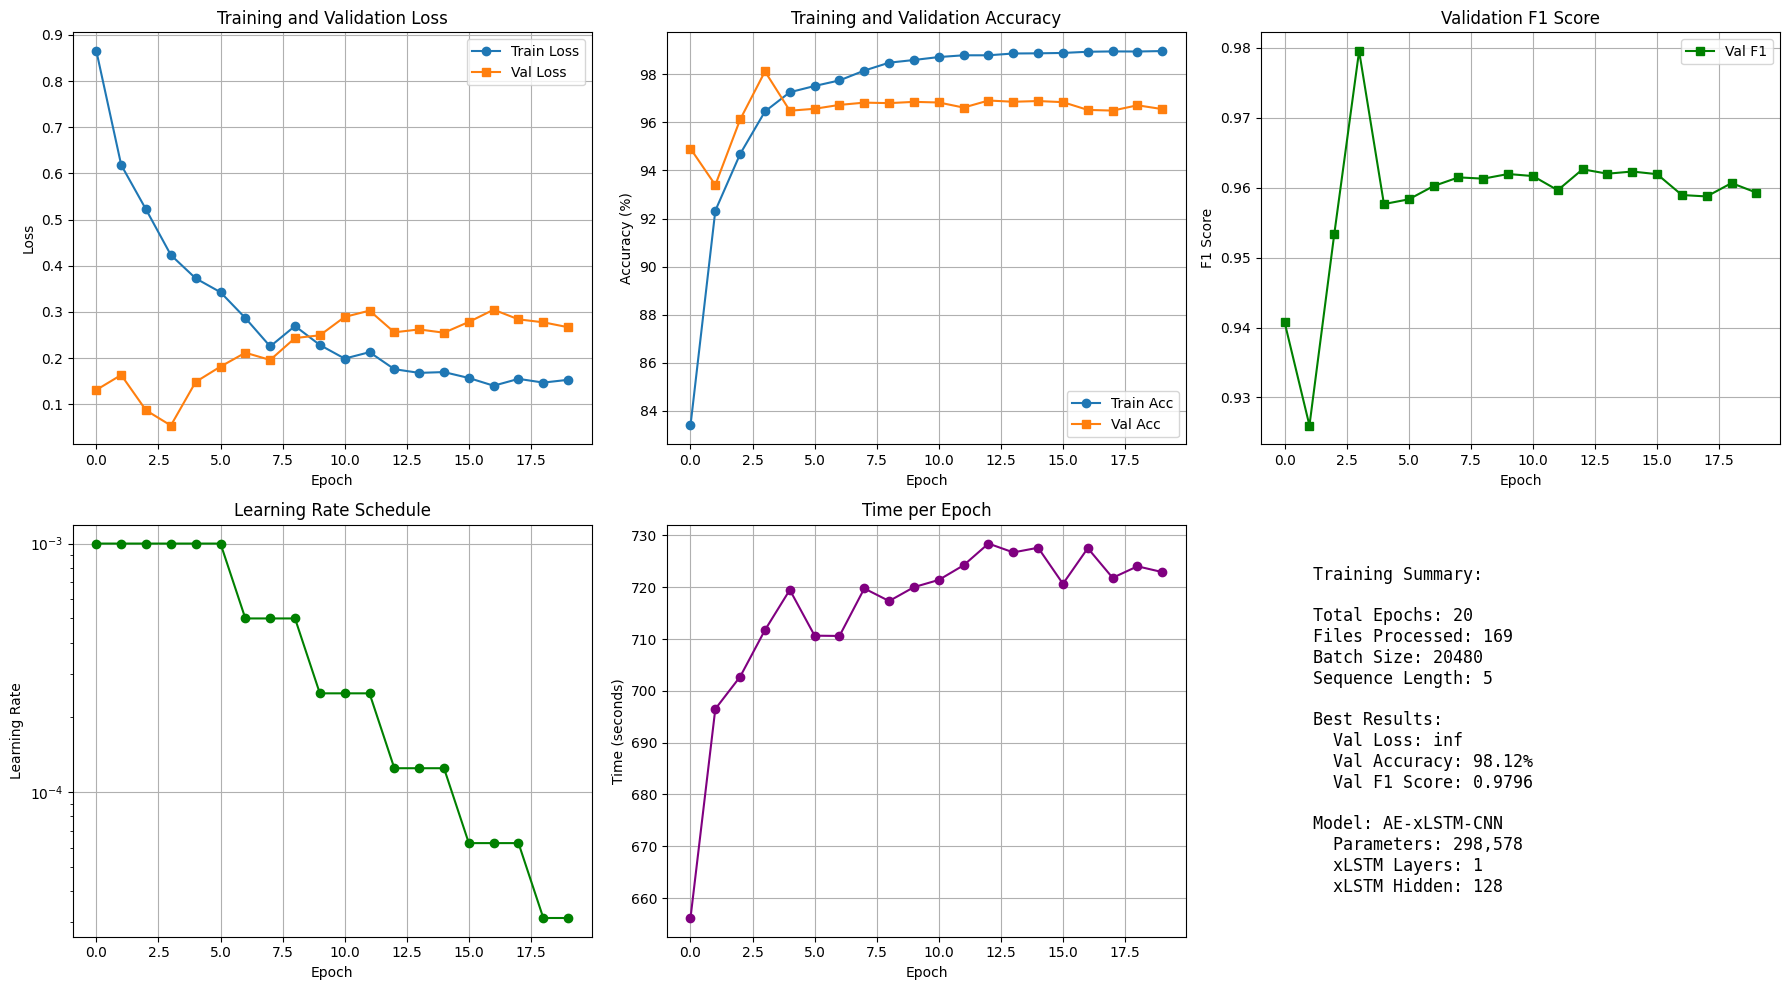

Training plots saved as 'training_history_xlstm.png'


In [22]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1 Score
axes[0, 2].plot(history['val_f1'], label='Val F1', marker='s', color='green')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('F1 Score')
axes[0, 2].set_title('Validation F1 Score')
axes[0, 2].legend()
axes[0, 2].grid(True)

# Learning rate
axes[1, 0].plot(history['learning_rates'], marker='o', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True)
axes[1, 0].set_yscale('log')

# Epoch time
if 'epoch_time' in history:
    axes[1, 1].plot(history['epoch_time'], marker='o', color='purple')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].set_title('Time per Epoch')
    axes[1, 1].grid(True)

# Best metrics
axes[1, 2].axis('off')
summary_text = f"""
Training Summary:

Total Epochs: {EPOCHS}
Files Processed: {len(csv_files)}
Batch Size: {BATCH_SIZE}
Sequence Length: {SEQUENCE_LENGTH}

Best Results:
  Val Loss: {best_val_loss:.4f}
  Val Accuracy: {best_val_acc:.2f}%
  Val F1 Score: {max(history['val_f1']):.4f}

Model: AE-xLSTM-CNN
  Parameters: {trainable_params:,}
  xLSTM Layers: {XLSTM_LAYERS}
  xLSTM Hidden: {XLSTM_HIDDEN}
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=12, family='monospace', 
                verticalalignment='center')

plt.tight_layout()
plt.savefig('training_history_xlstm.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training plots saved as 'training_history_xlstm.png'")

## Load Best Model and Final Evaluation

In [23]:
def evaluate(model, dataloader, criterion_cls, criterion_ae):
    """
    Evaluate model on a dataloader
    
    Returns:
        total_loss, cls_loss, ae_loss, accuracy, predictions, true_labels
    """
    model.eval()
    
    total_loss = 0
    total_cls_loss = 0
    total_ae_loss = 0
    total_correct = 0
    total_samples = 0
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(dataloader, desc="Evaluating"):
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            
            # Forward pass
            if scaler is not None:
                with autocast(device_type='cuda'):
                    outputs, reconstruction = model(X_batch)
                    
                    loss_cls = criterion_cls(outputs, y_batch)
                    loss_ae = criterion_ae(reconstruction, X_batch)
                    loss = loss_cls + 0.1 * loss_ae
            else:
                outputs, reconstruction = model(X_batch)
                
                loss_cls = criterion_cls(outputs, y_batch)
                loss_ae = criterion_ae(reconstruction, X_batch)
                loss = loss_cls + 0.1 * loss_ae
            
            # Accumulate losses
            total_loss += loss.item() * y_batch.size(0)
            total_cls_loss += loss_cls.item() * y_batch.size(0)
            total_ae_loss += loss_ae.item() * y_batch.size(0)
            
            # Predictions
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)
            
            # Store for metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / total_samples
    avg_cls_loss = total_cls_loss / total_samples
    avg_ae_loss = total_ae_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    
    return avg_loss, avg_cls_loss, avg_ae_loss, accuracy, all_predictions, all_labels

print("Evaluation function defined")

Evaluation function defined


In [24]:
# Load best model
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"Validation Accuracy: {checkpoint['val_acc']:.2f}%")
if 'val_f1' in checkpoint:
    print(f"Validation F1 Score: {checkpoint['val_f1']:.4f}")

Best model loaded from epoch 4
Validation Loss: 0.0540
Validation Accuracy: 98.12%
Validation F1 Score: 0.9796


In [25]:
# Final evaluation on a test file (use last file as test)
if len(csv_files) > 10:
    test_file = csv_files[-1]
    print(f"Final evaluation on: {os.path.basename(test_file)}")
    
    # Use validate_on_file which now returns F1 score
    test_loss, test_acc, test_samples, test_preds, test_labels, test_f1 = validate_on_file(
        model, test_file, global_scaler, global_label_encoder
    )
    
    print(f"\nTest Results:")
    print(f"  Loss: {test_loss:.4f}")
    print(f"  Accuracy: {test_acc:.2f}%")
    print(f"  F1 Score: {test_f1:.4f}")
    print(f"  Samples: {test_samples:,}")
    
    # Classification report
    if len(test_preds) > 0 and len(test_labels) > 0:
        print("\nClassification Report:")
        label_names = global_label_encoder.classes_
        print(classification_report(test_labels, test_preds, 
                                   target_names=label_names, 
                                   zero_division=0))
    
    gc.collect()
else:
    print("Not enough files for separate test evaluation")

Final evaluation on: part-00168-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv

Test Results:
  Loss: 0.0532
  Accuracy: 98.18%
  F1 Score: 0.9802
  Samples: 234,741

Classification Report:
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        26
          BenignTraffic       0.77      0.98      0.86      5481
       BrowserHijacking       0.00      0.00      0.00        23
       CommandInjection       1.00      0.09      0.17        33
 DDoS-ACK_Fragmentation       0.99      0.98      0.99      1501
        DDoS-HTTP_Flood       0.69      0.73      0.71       143
        DDoS-ICMP_Flood       1.00      1.00      1.00     36394
DDoS-ICMP_Fragmentation       0.97      0.98      0.98      2268
      DDoS-PSHACK_Flood       1.00      1.00      1.00     20508
       DDoS-RSTFINFlood       1.00      1.00      1.00     20365
         DDoS-SYN_Flood       1.00      0.96      0.98     20343
         DDoS-SlowLoris       


CONFUSION MATRIX ANALYSIS

Confusion Matrix Shape: (34, 34)
Total Classes: 34


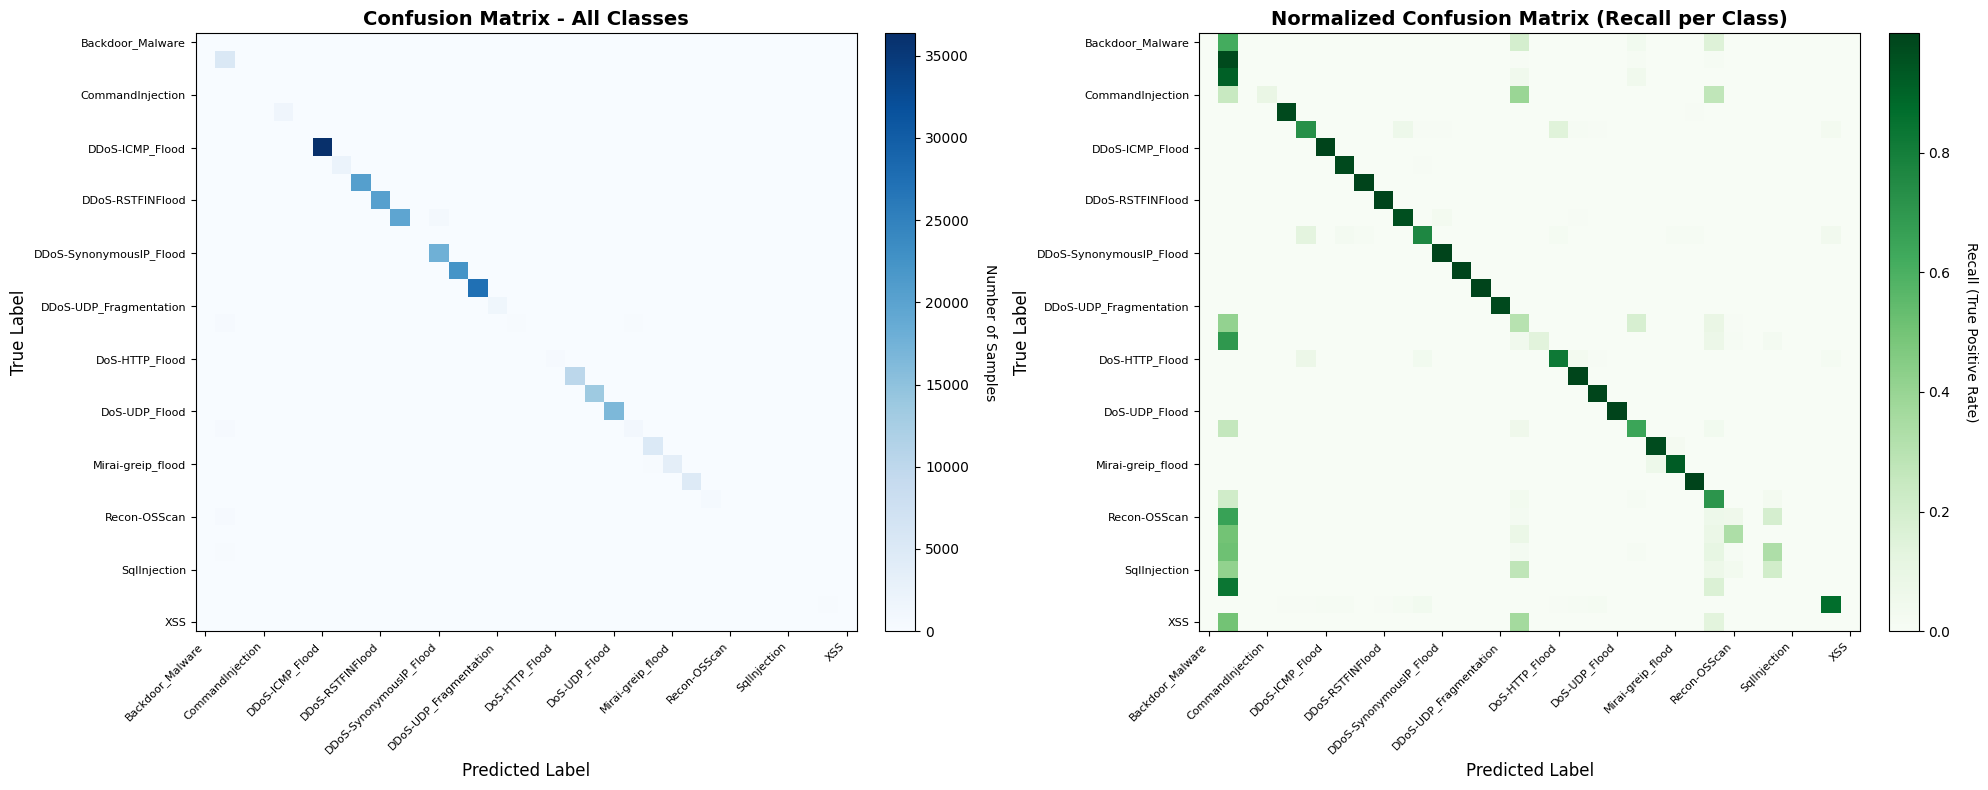


✓ Confusion matrix saved as 'confusion_matrix_xlstm.png'

PER-CLASS METRICS (TP, TN, FP, FN)

Top 10 Classes by Support:
                  Class    TP  FP  FN     TN  Precision   Recall  F1-Score  Support
        DDoS-ICMP_Flood 36365  10  29 198337   0.999725 0.999203  0.999464    36394
         DDoS-UDP_Flood 27278  37  48 207378   0.998645 0.998243  0.998444    27326
         DDoS-TCP_Flood 22374  51  47 212269   0.997726 0.997904  0.997815    22421
      DDoS-PSHACK_Flood 20487  13  21 214220   0.999366 0.998976  0.999171    20508
       DDoS-RSTFINFlood 20346   1  19 214375   0.999951 0.999067  0.999509    20365
         DDoS-SYN_Flood 19583  69 760 214329   0.996489 0.962641  0.979272    20343
DDoS-SynonymousIP_Flood 17764 645  43 216289   0.964963 0.997585  0.981003    17807
          DoS-UDP_Flood 16585  28  68 218060   0.998315 0.995917  0.997114    16653
          DoS-TCP_Flood 13568  44  73 221056   0.996768 0.994648  0.995707    13641
          DoS-SYN_Flood 10097 150  66 

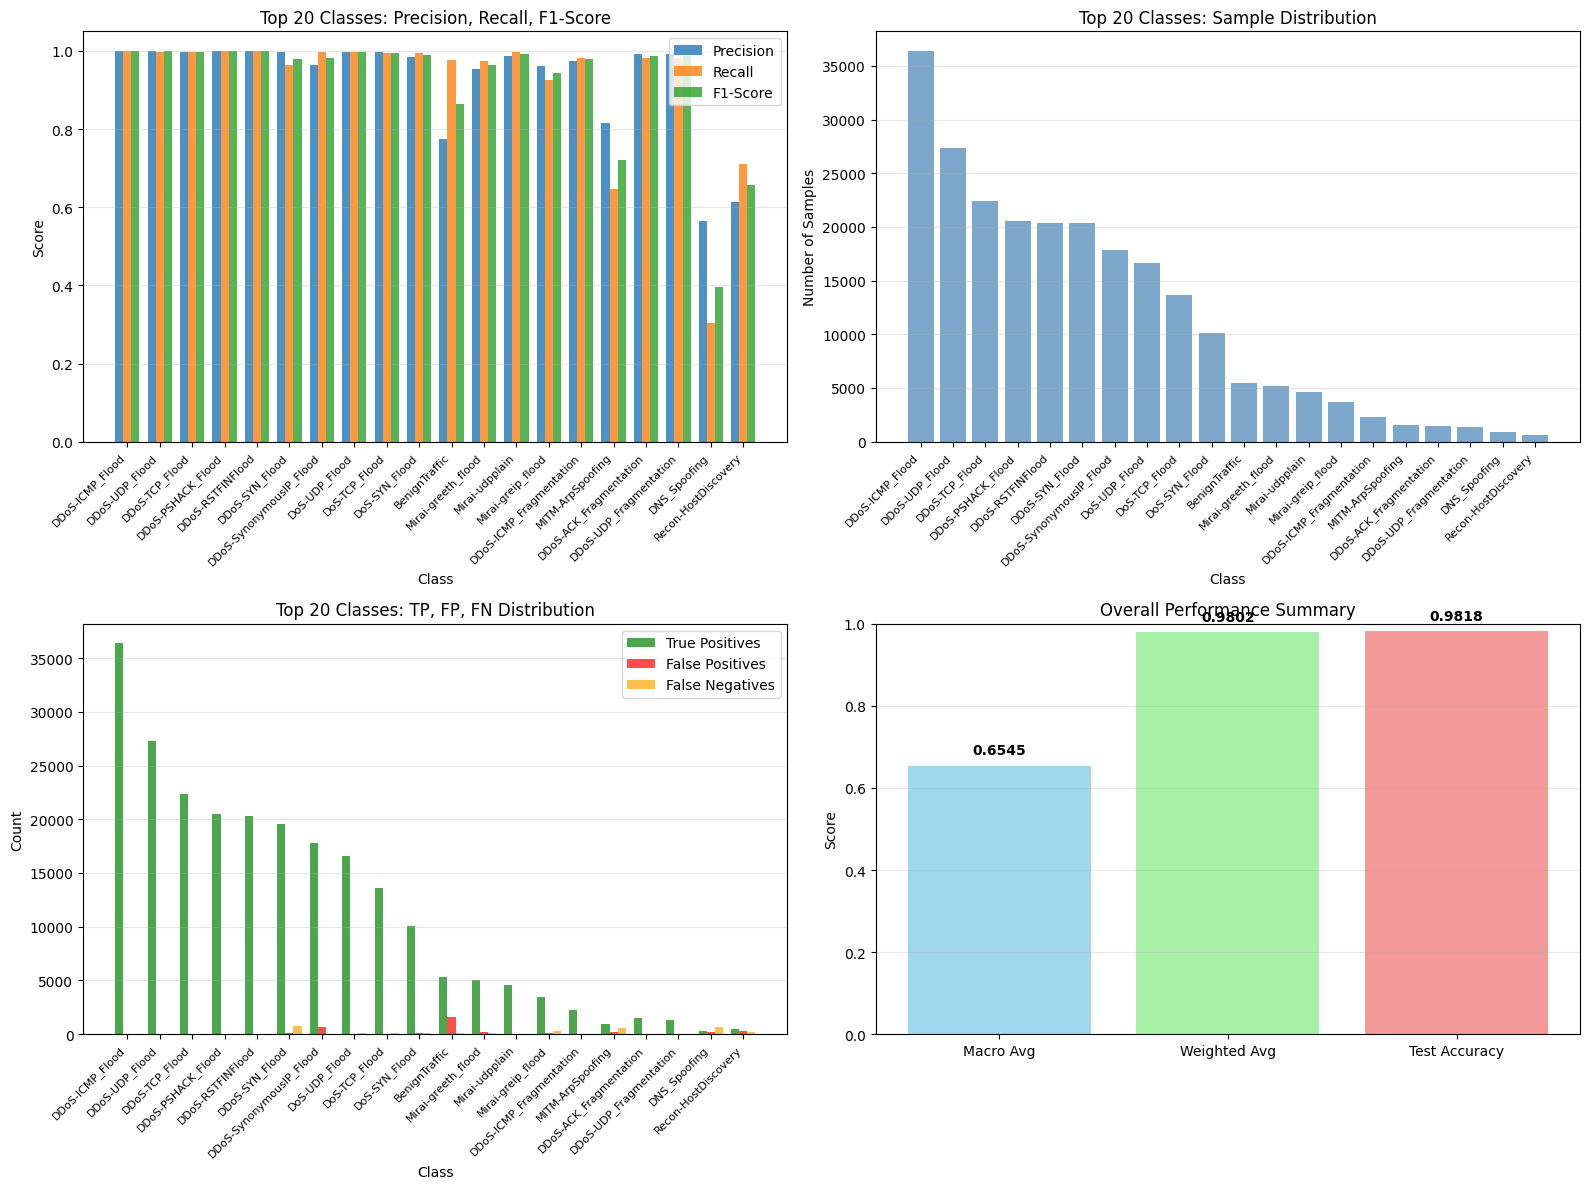


✓ Per-class performance plots saved to 'per_class_performance.png'



In [26]:
# Confusion Matrix Visualization and Analysis
if len(csv_files) > 10 and len(test_preds) > 0 and len(test_labels) > 0:
    print("\n" + "="*80)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*80)
    
    # Compute confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    
    # Get class names
    class_names = global_label_encoder.classes_
    n_classes = len(class_names)
    
    print(f"\nConfusion Matrix Shape: {cm.shape}")
    print(f"Total Classes: {n_classes}")
    
    # ===== VISUALIZATION =====
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Full confusion matrix (heatmap)
    im1 = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect='auto')
    axes[0].set_title('Confusion Matrix - All Classes', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Number of Samples', rotation=270, labelpad=20)
    
    # Set tick labels (show every nth label to avoid crowding)
    tick_step = max(1, n_classes // 10)  # Show ~10 labels max
    tick_marks = np.arange(0, n_classes, tick_step)
    axes[0].set_xticks(tick_marks)
    axes[0].set_yticks(tick_marks)
    axes[0].set_xticklabels([class_names[i] for i in tick_marks], rotation=45, ha='right', fontsize=8)
    axes[0].set_yticklabels([class_names[i] for i in tick_marks], fontsize=8)
    
    # Plot 2: Normalized confusion matrix (percentage)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero
    
    im2 = axes[1].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greens, aspect='auto')
    axes[1].set_title('Normalized Confusion Matrix (Recall per Class)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar2.set_label('Recall (True Positive Rate)', rotation=270, labelpad=20)
    
    # Set tick labels
    axes[1].set_xticks(tick_marks)
    axes[1].set_yticks(tick_marks)
    axes[1].set_xticklabels([class_names[i] for i in tick_marks], rotation=45, ha='right', fontsize=8)
    axes[1].set_yticklabels([class_names[i] for i in tick_marks], fontsize=8)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_xlstm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Confusion matrix saved as 'confusion_matrix_xlstm.png'")
    
    # ===== PER-CLASS METRICS (TP, TN, FP, FN) =====
    print("\n" + "="*80)
    print("PER-CLASS METRICS (TP, TN, FP, FN)")
    print("="*80)
    
    # Calculate metrics for each class
    metrics_data = []
    
    for i, class_name in enumerate(class_names):
        # True Positives: correctly predicted as this class
        tp = cm[i, i]
        
        # False Positives: incorrectly predicted as this class
        fp = cm[:, i].sum() - tp
        
        # False Negatives: should be this class but predicted as others
        fn = cm[i, :].sum() - tp
        
        # True Negatives: correctly predicted as NOT this class
        tn = cm.sum() - tp - fp - fn
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        support = tp + fn  # Total actual samples of this class
        
        metrics_data.append({
            'Class': class_name,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Support': support
        })
    
    # Create DataFrame for better visualization
    metrics_df = pd.DataFrame(metrics_data)
    
    # Display top 10 classes by support
    print("\nTop 10 Classes by Support:")
    print(metrics_df.nlargest(10, 'Support')[['Class', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1-Score', 'Support']].to_string(index=False))
    
    # Display classes with lowest F1 scores (potential problem classes)
    print("\n\nBottom 10 Classes by F1-Score (Need Improvement):")
    print(metrics_df.nsmallest(10, 'F1-Score')[['Class', 'TP', 'FP', 'FN', 'TN', 'Precision', 'Recall', 'F1-Score', 'Support']].to_string(index=False))
    
    # ===== OVERALL AGGREGATE METRICS =====
    print("\n" + "="*80)
    print("OVERALL AGGREGATE METRICS")
    print("="*80)
    
    total_tp = metrics_df['TP'].sum()
    total_tn = metrics_df['TN'].sum()
    total_fp = metrics_df['FP'].sum()
    total_fn = metrics_df['FN'].sum()
    
    overall_accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
    
    print(f"\nTotal True Positives (TP):  {total_tp:,}")
    print(f"Total True Negatives (TN):  {total_tn:,}")
    print(f"Total False Positives (FP): {total_fp:,}")
    print(f"Total False Negatives (FN): {total_fn:,}")
    print(f"\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    
    # Macro averages
    macro_precision = metrics_df['Precision'].mean()
    macro_recall = metrics_df['Recall'].mean()
    macro_f1 = metrics_df['F1-Score'].mean()
    
    # Weighted averages
    weighted_precision = (metrics_df['Precision'] * metrics_df['Support']).sum() / metrics_df['Support'].sum()
    weighted_recall = (metrics_df['Recall'] * metrics_df['Support']).sum() / metrics_df['Support'].sum()
    weighted_f1 = (metrics_df['F1-Score'] * metrics_df['Support']).sum() / metrics_df['Support'].sum()
    
    print(f"\nMacro-Average Metrics (unweighted):")
    print(f"  Precision: {macro_precision:.4f}")
    print(f"  Recall:    {macro_recall:.4f}")
    print(f"  F1-Score:  {macro_f1:.4f}")
    
    print(f"\nWeighted-Average Metrics (by support):")
    print(f"  Precision: {weighted_precision:.4f}")
    print(f"  Recall:    {weighted_recall:.4f}")
    print(f"  F1-Score:  {weighted_f1:.4f}")
    
    # ===== SAVE METRICS TO CSV =====
    metrics_df.to_csv('per_class_metrics.csv', index=False)
    print(f"\n✓ Per-class metrics saved to 'per_class_metrics.csv'")
    
    # ===== VISUALIZATION: Per-Class Performance =====
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Sort by support for better visualization
    metrics_df_sorted = metrics_df.sort_values('Support', ascending=False).head(20)
    
    # Plot 1: Precision, Recall, F1 for top 20 classes
    x = np.arange(len(metrics_df_sorted))
    width = 0.25
    
    axes[0, 0].bar(x - width, metrics_df_sorted['Precision'], width, label='Precision', alpha=0.8)
    axes[0, 0].bar(x, metrics_df_sorted['Recall'], width, label='Recall', alpha=0.8)
    axes[0, 0].bar(x + width, metrics_df_sorted['F1-Score'], width, label='F1-Score', alpha=0.8)
    axes[0, 0].set_xlabel('Class')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Top 20 Classes: Precision, Recall, F1-Score')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metrics_df_sorted['Class'], rotation=45, ha='right', fontsize=8)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Support distribution
    axes[0, 1].bar(x, metrics_df_sorted['Support'], color='steelblue', alpha=0.7)
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Number of Samples')
    axes[0, 1].set_title('Top 20 Classes: Sample Distribution')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(metrics_df_sorted['Class'], rotation=45, ha='right', fontsize=8)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot 3: TP vs FP vs FN
    axes[1, 0].bar(x - width, metrics_df_sorted['TP'], width, label='True Positives', color='green', alpha=0.7)
    axes[1, 0].bar(x, metrics_df_sorted['FP'], width, label='False Positives', color='red', alpha=0.7)
    axes[1, 0].bar(x + width, metrics_df_sorted['FN'], width, label='False Negatives', color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Top 20 Classes: TP, FP, FN Distribution')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics_df_sorted['Class'], rotation=45, ha='right', fontsize=8)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Plot 4: F1-Score comparison (macro vs weighted)
    summary_metrics = ['Macro Avg', 'Weighted Avg', 'Test Accuracy']
    summary_values = [macro_f1, weighted_f1, test_acc/100]
    colors = ['skyblue', 'lightgreen', 'lightcoral']
    
    axes[1, 1].bar(summary_metrics, summary_values, color=colors, alpha=0.8)
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Overall Performance Summary')
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(summary_values):
        axes[1, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Per-class performance plots saved to 'per_class_performance.png'")
    
    print("\n" + "="*80)